### INSTALLING AND IMPORTING NECESSARY LIBRARIES AND PACKAGES ###

In [ ]:
!pip install pandas
!pip install scikit-plot
!pip install seaborn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io
import json
from scipy import stats
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification

In [2]:
# Empty dictionary to store accuracy values of all 3 models for each experimental iteration. 
# For Example: we store lists inside this master list and each list contains the accuracy score of 3 models -> [[95,94,94],[],[]...]
accuracy_comparision = {}

### DEFINITIONS FOR FUNCTIONS USED THROUGHOUT THE CODE ###

In [3]:
# # Function to plot learning curves
# def plot_learning_curve(model, xTrain, yTrain, title, cv=5, scoring="accuracy"):
#     train_sizes, train_scores, test_scores = learning_curve(
#         model, xTrain, yTrain, cv=cv, scoring=scoring, n_jobs=-1, train_sizes=np.linspace(0.2, 1.0, 5)
#     )

#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)

#     plt.figure(figsize=(10, 6))
#     plt.grid()

#     # Plot learning curve
#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1, color="r")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

#     plt.title(f"Learning Curve for {title}")
#     plt.xlabel("Training Examples")
#     plt.ylabel("Score")
#     plt.legend(loc="best")
#     plt.show()

In [4]:
def plot_learning_curve(model, xTrain, yTrain, title, cv=5, scoring="accuracy"):
    train_sizes = np.linspace(0.2, 1.0, 5)  # Adjusted to prevent small splits
    train_sizes, train_scores, test_scores = learning_curve(
        model, xTrain, yTrain, cv=cv, scoring=scoring, n_jobs=-1, train_sizes=train_sizes
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.grid()

    # Plot learning curve
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.title(f"Learning Curve for {title}")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

In [5]:
# Function for calling SKLearn Logistic Regression, plot the learning curve and return evaluation metrics.

#Pass 4 different pandas dataframes - first split into train test split, then into x for independent variables and y containing the dependent variable.
def logistic_regression(xTrain, xTest, yTrain, yTest, penalty='none'):

    penalty_param = None if penalty == 'none' else penalty
    # Validate penalty
    valid_penalties = [None, 'l1', 'l2', 'elasticnet']
    if penalty_param not in valid_penalties:
        raise ValueError(f"Invalid penalty '{penalty}'. Choose from 'none', 'l1', 'l2', or 'elasticnet'.")
    # Choose solver based on penalty
    solver = 'saga' if penalty_param in ['l1', 'elasticnet'] else 'lbfgs'
    
    # Initiate the SKLearn Logistic Regression object
    logistic_regression = LogisticRegression(penalty=penalty_param, solver=solver, max_iter = 3000)
    logistic_regression.fit(xTrain, yTrain)

    # Use object to test on testing set
    yPrediction = logistic_regression.predict(xTest)
    prob_y_prediction = logistic_regression.predict_proba(xTest)[:,1]

    #Calculate Accuracy, Precision, Recall and F1.
    accuracy = accuracy_score(yTest, yPrediction)
    classification_rep = classification_report(yTest, yPrediction)

    #Store Evaluation metrics in a dictionary and return it
    evaluation = {"Accuracy:": accuracy, "Classification Report:\n" : classification_rep}

    #Plot learning curves using the function plot_learning_curve()
    plot_learning_curve(logistic_regression, xTrain, yTrain, "Logistic Regression")

    return evaluation

In [150]:
# Function for calling SKLearn Logistic Regression, plot the learning curve and return evaluation metrics.

#Pass 4 different pandas dataframes - first split into train test split, then into x for independent variables and y containing the dependent variable.
def log_reg_return_model_only(xTrain, xTest, yTrain, yTest, penalty='none'):

    penalty_param = None if penalty == 'none' else penalty
    # Validate penalty
    valid_penalties = [None, 'l1', 'l2', 'elasticnet']
    if penalty_param not in valid_penalties:
        raise ValueError(f"Invalid penalty '{penalty}'. Choose from 'none', 'l1', 'l2', or 'elasticnet'.")
    # Choose solver based on penalty
    solver = 'saga' if penalty_param in ['l1', 'elasticnet'] else 'lbfgs'
    
    # Initiate the SKLearn Logistic Regression object
    logistic_regression = LogisticRegression(penalty=penalty_param, solver=solver, max_iter = 3000)
    logistic_regression.fit(xTrain, yTrain)

    # Use object to test on testing set
    yPrediction = logistic_regression.predict(xTest)
    prob_y_prediction = logistic_regression.predict_proba(xTest)[:,1]

    return logistic_regression

In [151]:
def plot_logistic_lollipop(model, feature_names=None, title="Logistic Regression Coefficients"):
    """
    Plots a lollipop chart for logistic regression coefficients.

    Parameters:
    - model: A trained LogisticRegression model.
    - feature_names: List of feature names (default: uses index numbers if None).
    - title: Title of the plot.
    """

    # Extract coefficients
    coef_values = model.coef_.flatten()  # Flatten in case of a single-class logistic regression
    feature_names_sub = []
    for i in range(len(coef_values)):
        feature_names_sub.append(i)
    feature_names = feature_names if feature_names else feature_names_sub

    # Create DataFrame for sorting
    coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coef_values})
    coef_df = coef_df.sort_values(by="Coefficient", key=abs, ascending=False)  # Sort by absolute values

    # Plot lollipop chart
    plt.figure(figsize=(18, 16))
    plt.hlines(y=coef_df["Feature"], xmin=0, xmax=coef_df["Coefficient"], color="gray", linewidth=1.5)  # Lines
    plt.scatter(coef_df["Coefficient"], coef_df["Feature"], color=np.where(coef_df["Coefficient"] > 0, "skyblue", "coral"), s=100)  # Dots
    
    # Add reference line at zero
    plt.axvline(0, color="black", linestyle="--", linewidth=1.2)

    # Labels and title
    plt.xlabel("Coefficient Value")
    plt.ylabel("Features")
    plt.title(title)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()

In [7]:
# # Function for calling SKLearn Classification Tree, plot the learning curve and returns evaluation metrics.

# #Pass 4 different pandas dataframes - first split into train test split, then into x for independent variables and y containing dependent variable.
# def classification_tree(xTrain, xTest, yTrain, yTest):
#     # Initiate the SKLearn Random Forest object
#     classification_tree = DecisionTreeClassifier(random_state = 42)
#     classification_tree.fit(xTrain, yTrain)

#     # Use object to test on testing set
#     y_prediction = classification_tree.predict(xTest)

#     #Calculate Accuracy, Precision, Recall and F1.
#     accuracy = accuracy_score(yTest, y_prediction)
#     classification_rep = classification_report(yTest, y_prediction)
    
#     #Store Evaluation metrics in a dictionary and return it
#     evaluation = {"Accuracy:": accuracy, "Classification Report:\n" : classification_rep}

#     #Plot learning curves using the function plot_learning_curve()
#     plot_learning_curve(classification_tree, xTrain, yTrain, "Classfication Tree")

#     return evaluation

In [8]:
def classification_tree(xTrain, xTest, yTrain, yTest):
    # Initiate the SKLearn Classification Tree with regularization
    classification_tree = DecisionTreeClassifier(
        max_depth=9, min_samples_split=5, min_samples_leaf=3, random_state=42
    )
    classification_tree.fit(xTrain, yTrain)

    # Use object to test on testing set
    y_prediction = classification_tree.predict(xTest)

    # Calculate Accuracy, Precision, Recall, and F1-score
    accuracy = accuracy_score(yTest, y_prediction)
    classification_rep = classification_report(yTest, y_prediction)

    # Store Evaluation metrics in a dictionary and return it
    evaluation = {
        "Accuracy:": accuracy, 
        "Classification Report:\n": classification_rep
    }

    # Plot learning curves using the function plot_learning_curve()
    plot_learning_curve(classification_tree, xTrain, yTrain, "Classification Tree")

    return evaluation

In [9]:
# # Function for calling SKLearn Random Forest, plot the learning curve and returns evaluation metrics.

# #Pass 4 different pandas dataframes - first split into train test split, then into x for independent variables and y containing dependent variable.
# def random_forest(xTrain, xTest, yTrain, yTest):
#     # Initiate the SKLearn Random Forest object
#     random_forest = RandomForestClassifier(n_estimators=100,max_features='sqrt')
#     random_forest.fit(xTrain,yTrain)
    
#     # Use object to test on testing set
#     yPrediction = random_forest.predict(xTest)
#     prob_y_prediction = random_forest.predict_proba(xTest)[:,1]
    
#     #Calculate Accuracy, Precision, Recall and F1.
#     accuracy = accuracy_score(yTest, yPrediction)
#     classification_rep = classification_report(yTest, yPrediction)

#     #Store Evaluation metrics in a dictionary and return it
#     evaluation = {"Accuracy:": accuracy, "Classification Report:\n" : classification_rep}

#     #Plot learning curves using the function plot_learning_curve()
#     plot_learning_curve(random_forest, xTrain, yTrain, "Random Forest")

#     return evaluation

In [10]:
# Function for calling SKLearn Random Forest, plot the learning curve and return evaluation metrics
def random_forest(xTrain, xTest, yTrain, yTest):
    assert list(xTrain.columns) == list(xTest.columns), "Feature names do not match between training and test sets!"

    # Initiate the SKLearn Random Forest object
    random_forest = RandomForestClassifier(n_estimators=100, max_features='sqrt', 
                                       max_depth=10, min_samples_split=5, 
                                       min_samples_leaf=3, random_state=42)
    random_forest.fit(xTrain, yTrain)
    
    # Use object to test on testing set
    yPrediction = random_forest.predict(xTest)
    prob_y_prediction = random_forest.predict_proba(xTest)[:, 1]  # Get probability scores

    # Calculate Accuracy, Precision, Recall, and F1-score
    accuracy = accuracy_score(yTest, yPrediction)
    classification_rep = classification_report(yTest, yPrediction)

    # Store Evaluation metrics in a dictionary and return it
    evaluation = {"Accuracy:": accuracy, "Classification Report:\n": classification_rep}

    # Plot learning curves using the function plot_learning_curve()
    plot_learning_curve(random_forest, xTrain, yTrain, "Random Forest")

    return evaluation

In [11]:
# Function to plot a bar graph of the accuracy values for each model. Takes 3 different values. 

# Pass the three different accuracy values for each model.
def plot_comparision_graph(log_reg_acc, dt_acc, rf_acc):
    fig, ax = plt.subplots()
    ax.bar(["Logistic Regression", "Classification Tree", "Random Forest"], [log_reg_acc,dt_acc,rf_acc], 
           label=["Logistic Regression", "Classification Tree", "Random Forest"], color= ['skyblue','lightcoral', 'chartreuse'], edgecolor = 'black')
    ax.set_ylabel('Accuracy')
    ax.set_title('Comparision between different models')
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}",  # Format height to 2 decimal places
                    (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom')
    plt.show()

In [12]:
# Function to plot histograms and box and whisker plots alongside each other for each feature in the dataset.

#Pass the dataset and the color you want the graph in.
def plot_hist_box(data,color):

    # Open and read the JSON file containing readable names for all the features.
    with open('custom_titles.json', 'r') as file:
        custom_titles = json.load(file)
    
    # num_features = data.shape[1]  # Number of features (columns)
    fig, axes = plt.subplots(data.shape[1], 2, figsize=(10, data.shape[1] * 3))

    # Loop through each feature
    for i, column in enumerate(data.columns):
        # Histogram
        sns.histplot(data[column], kde=True, ax=axes[i, 0], color=color )
        axes[i, 0].set_title(custom_titles[column])
        
        # Boxplot
        sns.boxplot(x=data[column], ax=axes[i, 1], color = color, linecolor = "black", linewidth=0.65, fliersize= 0.85)
        axes[i, 1].set_title(custom_titles[column])
    
    plt.tight_layout()
    plt.show()

In [13]:
# Function to plot countplots for each feature in the dataset.

#Pass either a Pandas Dataframe or a list of strings where the strings are the names of each feature.
#Pass the original dataframe which contains the 'status_encoded' variable just in case the primary dataframe ('data') doesn't contain that feature.
def count_plot(data, original_df):
    feature_list = []
    if isinstance(data, list):
        feature_list = data
    elif isinstance(data, pd.core.frame.DataFrame):
        feature_list = data.columns.tolist()
    else:
        print("Passed invalid Data Type. Pass either a List of strings or a Pandas DataFrame")
        return None
    no_cols = 2
    no_rows = len(feature_list) // no_cols + (len(feature_list) % no_cols > 0)  # Adjust row count based on features
    fig, ax = plt.subplots(no_rows, no_cols, figsize=(15, 60))
    for idx, column in enumerate(feature_list):
        row = idx // no_cols
        col = idx % no_cols
        a = sns.countplot(data=original_df, y=column, hue="status_encoded", palette="Set2", ax=ax[row, col])
        # Set legend and title per plot
        a.legend(title="URL Status", labels=['Legitimate', 'Phishing'],loc='upper center')
        a.set_title(f"Distribution of {column}")
        # Add the labels above the bars
        for container in a.containers:
            a.bar_label(container, fmt='%d', label_type='edge', fontsize=10)

    # Remove any unused subplots (if the grid has extra spaces)
    for extra_ax in ax[len(feature_list):]:
        extra_ax.remove()

    plt.tight_layout()
    plt.show()

In [14]:
def find_correlated_features(dataframe, correlation_threshold=0.9, target_column=None):
    """
    Identifies and returns features that are highly correlated with one another. Multicollinearity.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame with features.
    - correlation_threshold (float): The absolute correlation value above which features are considered highly correlated.
    - target_column (str, optional): The name of the target column to exclude from feature-to-feature correlation checks.

    Returns:
    - correlated_features (set): A set of features to consider removing due to high correlation.
    - correlation_matrix (pd.DataFrame): The full Pearson correlation matrix.
    """
    
    # Exclude the target column if provided
    if target_column:
        feature_data = dataframe.drop(columns=[target_column])
    else:
        feature_data = dataframe

    # Calculate the Pearson correlation matrix
    correlation_matrix = feature_data.corr()

    # List to store features that are highly correlated
    correlated_features = []

    # Iterate over the correlation matrix, considering each pair once
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            correlation_value = correlation_matrix.iloc[i, j]

            # Check if the absolute correlation value exceeds the threshold
            if abs(correlation_value) > correlation_threshold:
                # Add the second feature to the set for potential removal
                correlated_features.append((feature1,feature2))

    return correlated_features

### DATA UNDERSTANDING AND PRE-PROCESSING  ###

In [15]:
# Import Dataset
df = pd.read_csv("dataset_B_05_2020.csv")  #dataset_B_05_2020.csv

In [16]:
# Check no. of rows x columns
df.shape

(11430, 89)

In [17]:
#Check datatypes of each column
df.dtypes

url                object
length_url          int64
length_hostname     int64
ip                  int64
nb_dots             int64
                    ...  
web_traffic         int64
dns_record          int64
google_index        int64
page_rank           int64
status             object
Length: 89, dtype: object

In [18]:
#Check if there are any null values in dataset
df.isnull().values.any()

np.False_

In [19]:
# Verifying missing values (if any) across all features
print(df.isnull().sum())

url                0
length_url         0
length_hostname    0
ip                 0
nb_dots            0
                  ..
web_traffic        0
dns_record         0
google_index       0
page_rank          0
status             0
Length: 89, dtype: int64


In [20]:
# Total (if any) missing values
print(f"There are {df.isnull().sum().sum()} missing values in total.")

There are 0 missing values in total.


In [21]:
# Checking if dataset has any duplicate values based on our primary independent variable - URL
df.duplicated(subset = "url", keep = "first")

0        False
1        False
2        False
3        False
4        False
         ...  
11425    False
11426    False
11427    False
11428    False
11429    False
Length: 11430, dtype: bool

In [22]:
# Dataset distribution - Check the number of legitimate and phishing URLs to determine balance of dataset.
print(df["status"].value_counts())

status
legitimate    5715
phishing      5715
Name: count, dtype: int64


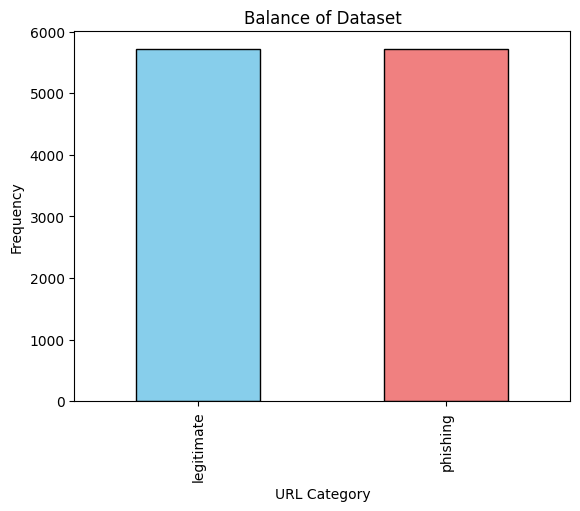

In [23]:
#Plot to visualise balance of dataset
df["status"].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'], edgecolor='black')
plt.xlabel('URL Category')
plt.ylabel('Frequency')
plt.title('Balance of Dataset')
plt.show()

**ONE HOT ENCODING OUR DEPENDENT VARIABLE 'status'**

In [24]:
# One Hot Encoding our Status Variable -> Legitimate as 0 and Phishing as 1.
df["status_encoded"] = df["status"].map({"legitimate" : 0, "phishing" : 1})

**DROPPING OUR DEPENDENT VARIABLE 'status' AND PRIMARY FEATURE 'url'**  
We drop 'url' because we have already extracted all the necessary features from it.

In [25]:
# Dropping URL and Status features, since they are not of use anymore.  
df = df.drop(labels = ['url', 'status'], axis = 'columns', inplace = False)

**PLOTTING THE NUMBER OF CONTINUOUS VS CATEGORICAL FEATURES**  

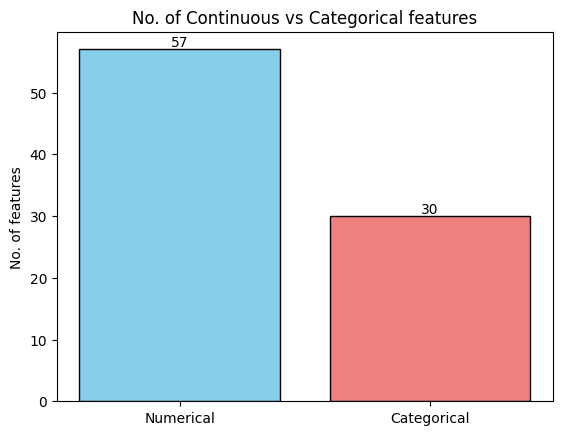

In [26]:
# Plotting the number of continuous vs categorical features
fig, ax = plt.subplots()
ax.bar(["Numerical", "Categorical"], [57,30], label=["Numerical", "Categorical"], color= ['skyblue','lightcoral'], edgecolor = 'black')
ax.set_ylabel('No. of features')
ax.set_title('No. of Continuous vs Categorical features')
for p in ax.patches:
   ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom')
plt.show()

**SPLITTING OUR DATASET INTO TRAINING, DEVELOPMENT AND TESTING SETS**

In [27]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
train_set, dev_set = train_test_split(train_set, test_size=0.25, random_state=42)  # 60/20/20 split

### ESTABLISHING A BASELINE PERFORMANCE ###

**CHECKING TO SEE HOW THE DATASET PERFORMS WITHOUT MAKING ANY CHANGES TO ESTABLISH A BASELINE THRESHOLD**

In [28]:
# Separating the dependent and independent variables in 2 datasets x and y.
x_train = train_set.drop(['status_encoded'], axis=1)
# Y will contain our response variable encoded with a numeric value of 0 for legitimate and 1 for phishing.
y_train = train_set["status_encoded"]
#DEV SET
# Separating the dependent and independent variables in 2 datasets x and y.
x_dev = dev_set.drop(['status_encoded'], axis=1)
# Y will contain our response variable encoded with a numeric value of 0 for legitimate and 1 for phishing.
y_dev = dev_set["status_encoded"]

C:\Users\Anindya Chakravarty\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


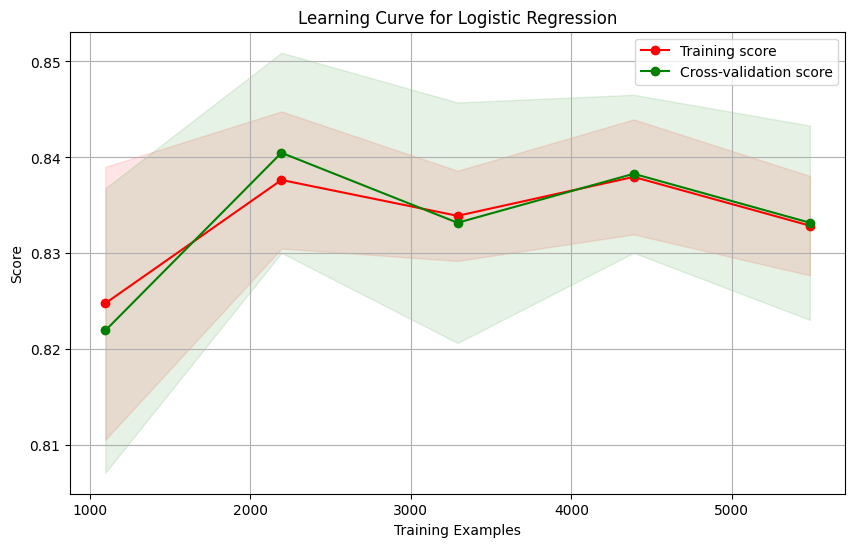

Accuracy::
0.821522309711286
Classification Report:
:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1098
           1       0.84      0.81      0.83      1188

    accuracy                           0.82      2286
   macro avg       0.82      0.82      0.82      2286
weighted avg       0.82      0.82      0.82      2286



In [29]:
log_reg_metrics = logistic_regression(x_train, x_dev, y_train, y_dev)
for key, value in log_reg_metrics.items():
    print(f"{key}:\n{value}")

We can see that we reach max iterations before we converge. Despite increasing the number of max iterations, it doesn't seem to converge.

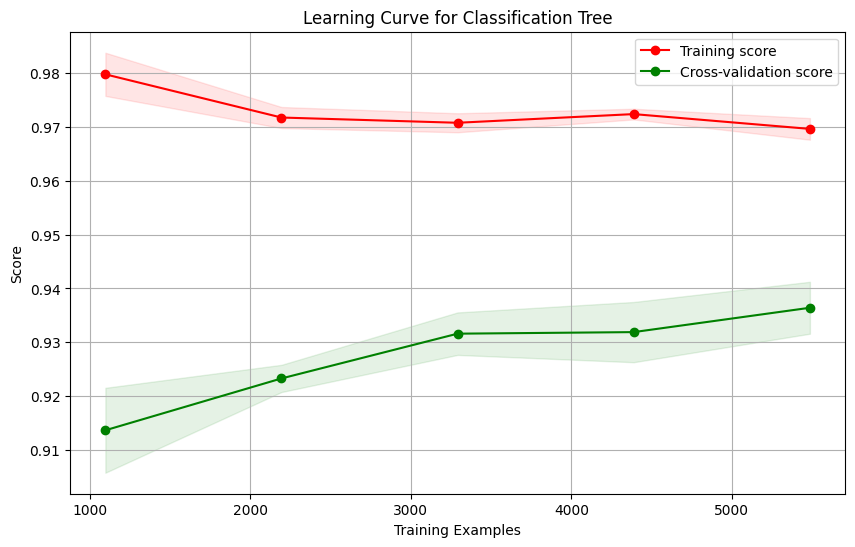

Accuracy:0.9291338582677166
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1098
           1       0.94      0.92      0.93      1188

    accuracy                           0.93      2286
   macro avg       0.93      0.93      0.93      2286
weighted avg       0.93      0.93      0.93      2286



In [30]:
classification_tree_metrics = classification_tree(x_train, x_dev, y_train, y_dev)
for key, value in classification_tree_metrics.items():
    print(f"{key}{value}")

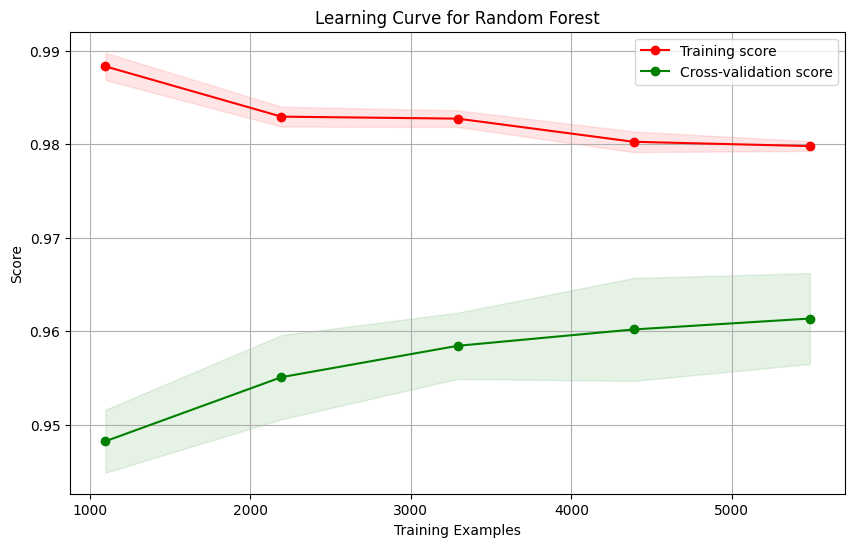

Accuracy:0.952755905511811
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1098
           1       0.96      0.95      0.95      1188

    accuracy                           0.95      2286
   macro avg       0.95      0.95      0.95      2286
weighted avg       0.95      0.95      0.95      2286



In [31]:
random_forest_metrics = random_forest(x_train, x_dev, y_train, y_dev)
for key, value in random_forest_metrics.items():
    print(f"{key}{value}")

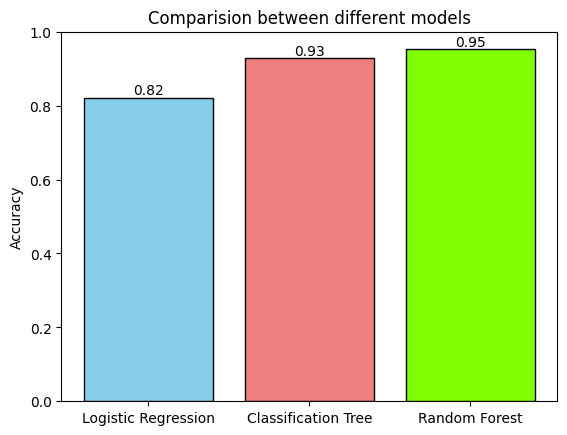

In [32]:
#Plot a bar graph comparing the accuracy for all three models
plot_comparision_graph(*[metrics['Accuracy:'] for metrics in [log_reg_metrics, classification_tree_metrics, random_forest_metrics]])

In [33]:
accuracy_comparision = {"Baseline":(log_reg_metrics['Accuracy:'],classification_tree_metrics['Accuracy:'],random_forest_metrics['Accuracy:'])}

### RUNNING MODELS ON 3 DIFFERENT DATASETS EACH CONTAINING DIFFERENT FEATURES RELATING TO THE URL ###

In [34]:
# List of URL based features 
url_based_features = ['length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 
                      'nb_or', 'nb_eq', 'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 
                      'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 
                      'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url', 'ratio_digits_host', 
                      'punycode', 'port', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains', 
                      'prefix_suffix', 'random_domain', 'shortening_service', 'path_extension', 'nb_redirection',
                      'nb_external_redirection', 'length_words_raw', 'char_repeat', 'shortest_words_raw',
                      'shortest_word_host','shortest_word_path', 'longest_words_raw', 'longest_word_host',
                      'longest_word_path', 'avg_words_raw','avg_word_host', 'avg_word_path', 'phish_hints', 
                      'domain_in_brand', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld', 'statistical_report']

# List of HTML and DOM content based features
content_based_features = ['nb_hyperlinks', 'ratio_intHyperlinks', 'ratio_extHyperlinks', 'ratio_nullHyperlinks', 'nb_extCSS', 'ratio_intRedirection',
                          'ratio_extRedirection', 'ratio_intErrors', 'ratio_extErrors', 'login_form', 'external_favicon', 'links_in_tags', 
                          'submit_email', 'ratio_intMedia', 'ratio_extMedia', 'sfh', 'iframe', 'popup_window', 'safe_anchor', 'onmouseover', 
                          'right_clic', 'empty_title', 'domain_in_title', 'domain_with_copyright']

# List of features based on external factors and reports
external_based_features = ['whois_registered_domain', 'domain_registration_length', 'domain_age', 'web_traffic', 'dns_record', 'google_index', 'page_rank']

In [35]:
print(
    f"No of URL based features - {len(url_based_features)}\
    \nNo of HTML and DOM content based features - {len(content_based_features)}\
    \nNo of features based on external factors and reports - {len(external_based_features)}\
    \nTotal features - {len(url_based_features) + len(content_based_features) + len(external_based_features)}"
)

No of URL based features - 56    
No of HTML and DOM content based features - 24    
No of features based on external factors and reports - 7    
Total features - 87


**OBSERVING MODEL PERFORMANCE USING ONLY URL BASED FEATURES**

In [36]:
# Creating dataframes containing URL based features and then splitting dependent and independent variables.
# Separating the dependent and independent variables in 2 datasets x and y.
x_train_url = train_set[url_based_features]
# Y will contain our response variable encoded with a numeric value of 0 for legitimate and 1 for phishing.
y_train_url = train_set["status_encoded"]
#DEV SET
# Separating the dependent and independent variables in 2 datasets x and y.
x_dev_url = dev_set[url_based_features]
# Y will contain our response variable encoded with a numeric value of 0 for legitimate and 1 for phishing.
y_dev_url = dev_set["status_encoded"]

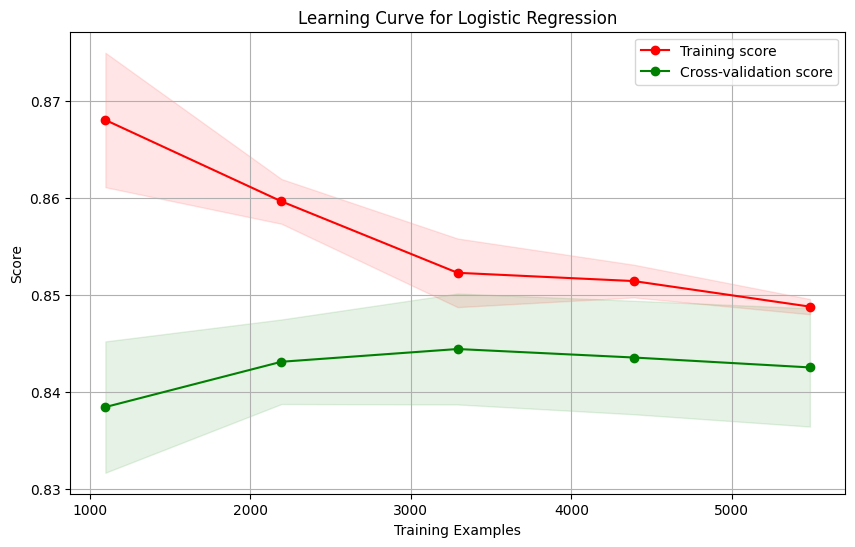

Accuracy::
0.8490813648293963
Classification Report:
:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1098
           1       0.88      0.82      0.85      1188

    accuracy                           0.85      2286
   macro avg       0.85      0.85      0.85      2286
weighted avg       0.85      0.85      0.85      2286



In [37]:
# Logistic Regression for URL based features
log_reg_metrics_url = logistic_regression(x_train_url, x_dev_url, y_train_url, y_dev_url)
for key, value in log_reg_metrics_url.items():
    print(f"{key}:\n{value}")

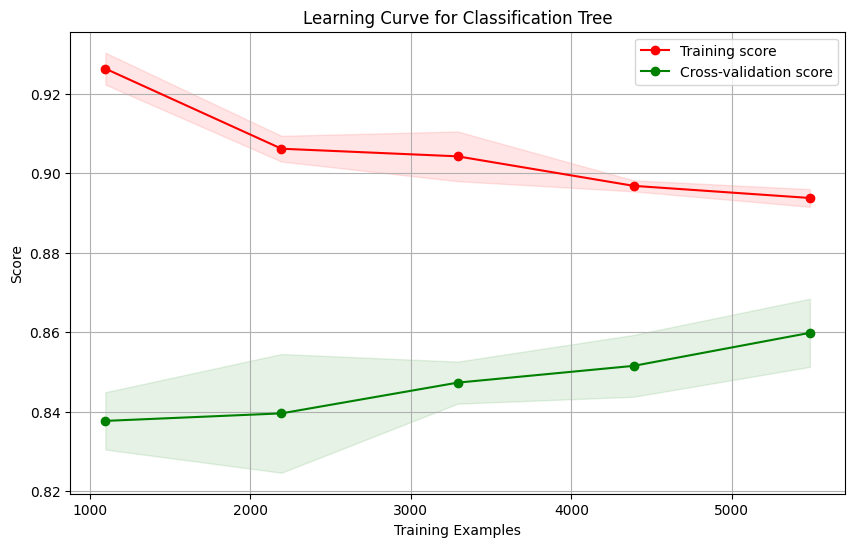

Accuracy:0.86832895888014
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1098
           1       0.86      0.89      0.88      1188

    accuracy                           0.87      2286
   macro avg       0.87      0.87      0.87      2286
weighted avg       0.87      0.87      0.87      2286



In [38]:
# Classification Tree for URL based features
classification_tree_metrics_url = classification_tree(x_train_url, x_dev_url, y_train_url, y_dev_url)
for key, value in classification_tree_metrics_url.items():
    print(f"{key}{value}")

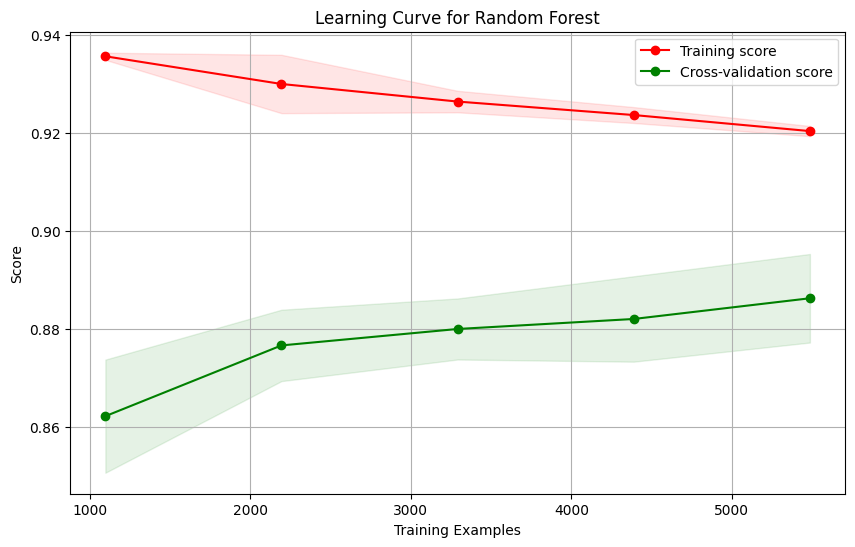

Accuracy:0.8884514435695539
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1098
           1       0.90      0.88      0.89      1188

    accuracy                           0.89      2286
   macro avg       0.89      0.89      0.89      2286
weighted avg       0.89      0.89      0.89      2286



In [39]:
# Random Forest for URL based features
random_forest_metrics_url = random_forest(x_train_url, x_dev_url, y_train_url, y_dev_url)
for key, value in random_forest_metrics_url.items():
    print(f"{key}{value}")

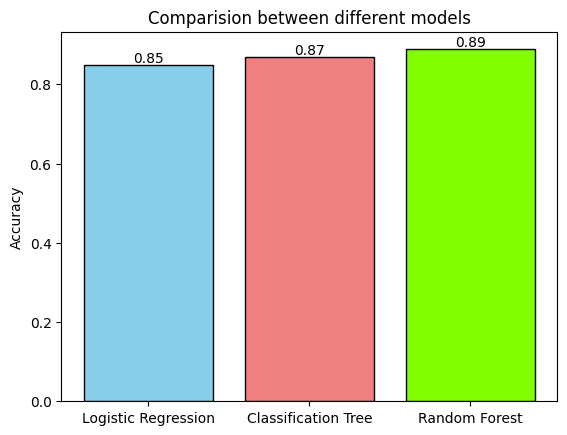

In [40]:
#Plot a bar graph comparing the accuracy for all three models
plot_comparision_graph(*[metrics['Accuracy:'] for metrics in [log_reg_metrics_url, classification_tree_metrics_url, random_forest_metrics_url]])

In [41]:
accuracy_comparision.update({"URL Based":(log_reg_metrics_url['Accuracy:'],classification_tree_metrics_url['Accuracy:'],random_forest_metrics_url['Accuracy:'])})

**HTML (CONTENT) BASED**

In [42]:
# Creating dataframes containing HTML and DOM content based features and then splitting dependent and independent variables.
# Separating the dependent and independent variables in 2 datasets x and y.
x_train_content = train_set[content_based_features]
# Y will contain our response variable encoded with a numeric value of 0 for legitimate and 1 for phishing.
y_train_content = train_set["status_encoded"]
#DEV SET
# Separating the dependent and independent variables in 2 datasets x and y.
x_dev_content = dev_set[content_based_features]
# Y will contain our response variable encoded with a numeric value of 0 for legitimate and 1 for phishing.
y_dev_content = dev_set["status_encoded"]

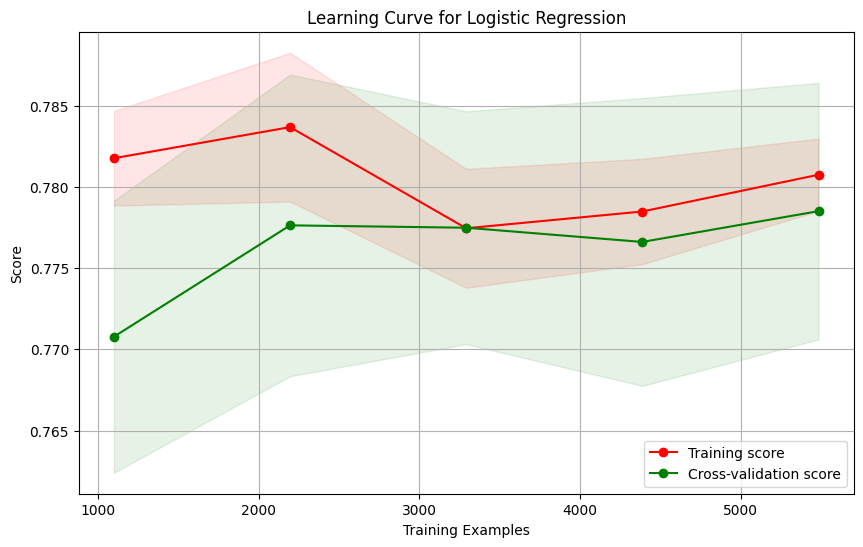

Accuracy::
0.7703412073490814
Classification Report:
:
              precision    recall  f1-score   support

           0       0.79      0.71      0.75      1098
           1       0.75      0.83      0.79      1188

    accuracy                           0.77      2286
   macro avg       0.77      0.77      0.77      2286
weighted avg       0.77      0.77      0.77      2286



In [43]:
# Logistic Regression for URL based features
log_reg_metrics_content = logistic_regression(x_train_content, x_dev_content, y_train_content, y_dev_content)
for key, value in log_reg_metrics_content.items():
    print(f"{key}:\n{value}")

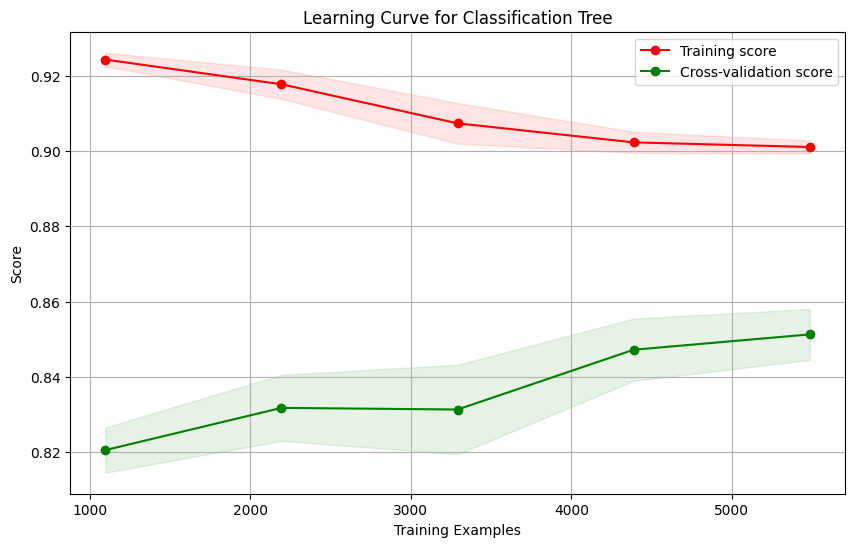

Accuracy:0.842082239720035
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1098
           1       0.85      0.85      0.85      1188

    accuracy                           0.84      2286
   macro avg       0.84      0.84      0.84      2286
weighted avg       0.84      0.84      0.84      2286



In [44]:
# Classification Tree for URL based features
classification_tree_metrics_content = classification_tree(x_train_content, x_dev_content, y_train_content, y_dev_content)
for key, value in classification_tree_metrics_content.items():
    print(f"{key}{value}")

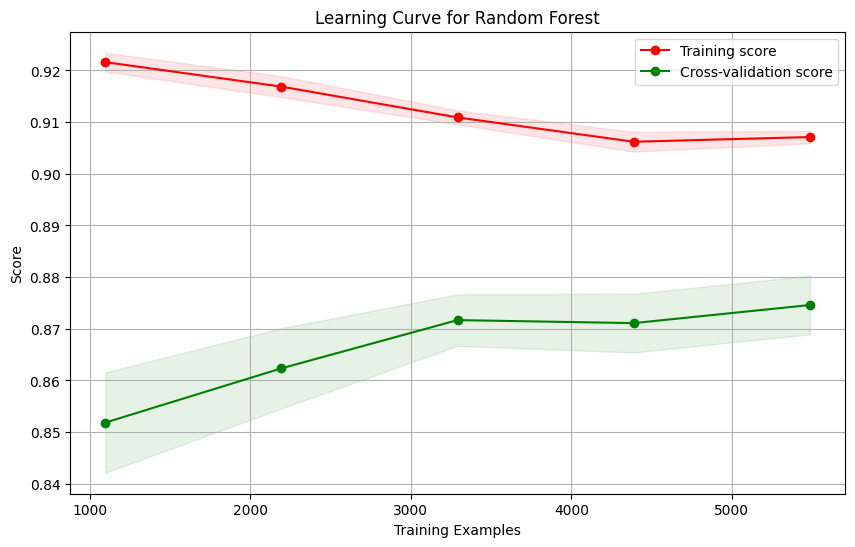

Accuracy:0.8582677165354331
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1098
           1       0.88      0.84      0.86      1188

    accuracy                           0.86      2286
   macro avg       0.86      0.86      0.86      2286
weighted avg       0.86      0.86      0.86      2286



In [45]:
# Random Forest for URL based features
random_forest_metrics_content = random_forest(x_train_content, x_dev_content, y_train_content, y_dev_content)
for key, value in random_forest_metrics_content.items():
    print(f"{key}{value}")

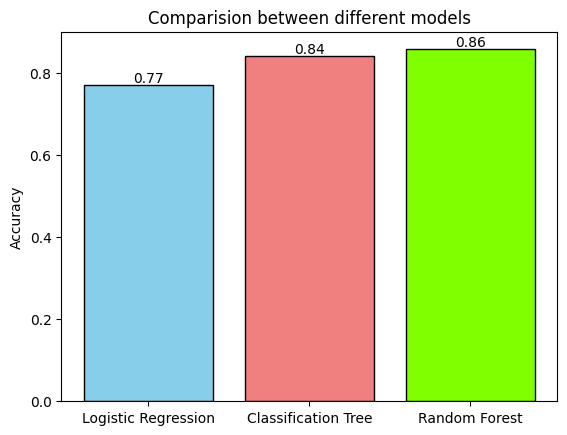

In [46]:
#Plot a bar graph comparing the accuracy for all three models
plot_comparision_graph(*[metrics['Accuracy:'] for metrics in 
                         [log_reg_metrics_content, classification_tree_metrics_content, random_forest_metrics_content]])

In [47]:
accuracy_comparision.update({"Content Based":(log_reg_metrics_content['Accuracy:'],classification_tree_metrics_content['Accuracy:'],random_forest_metrics_content['Accuracy:'])})

**EXTERNAL BASED**

In [48]:
# Creating dataframes containing External based features and then splitting dependent and independent variables.
# Separating the dependent and independent variables in 2 datasets x and y.
x_train_external = train_set[external_based_features]
# Y will contain our response variable encoded with a numeric value of 0 for legitimate and 1 for phishing.
y_train_external = train_set["status_encoded"]
#DEV SET
# Separating the dependent and independent variables in 2 datasets x and y.
x_dev_external = dev_set[external_based_features]
# Y will contain our response variable encoded with a numeric value of 0 for legitimate and 1 for phishing.
y_dev_external = dev_set["status_encoded"]

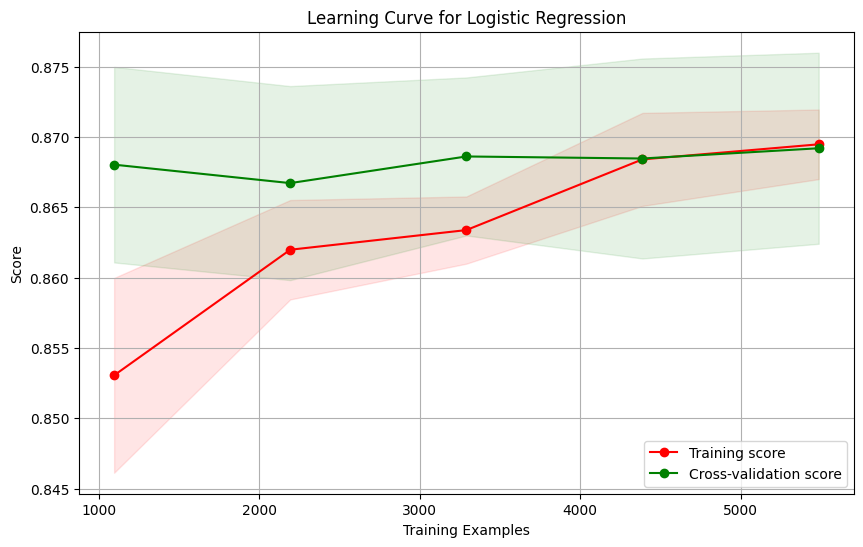

Accuracy::
0.8661417322834646
Classification Report:
:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1098
           1       0.87      0.87      0.87      1188

    accuracy                           0.87      2286
   macro avg       0.87      0.87      0.87      2286
weighted avg       0.87      0.87      0.87      2286



In [49]:
# Logistic Regression for URL based features
log_reg_metrics_external = logistic_regression(x_train_external, x_dev_external, y_train_external, y_dev_external)
for key, value in log_reg_metrics_external.items():
    print(f"{key}:\n{value}")

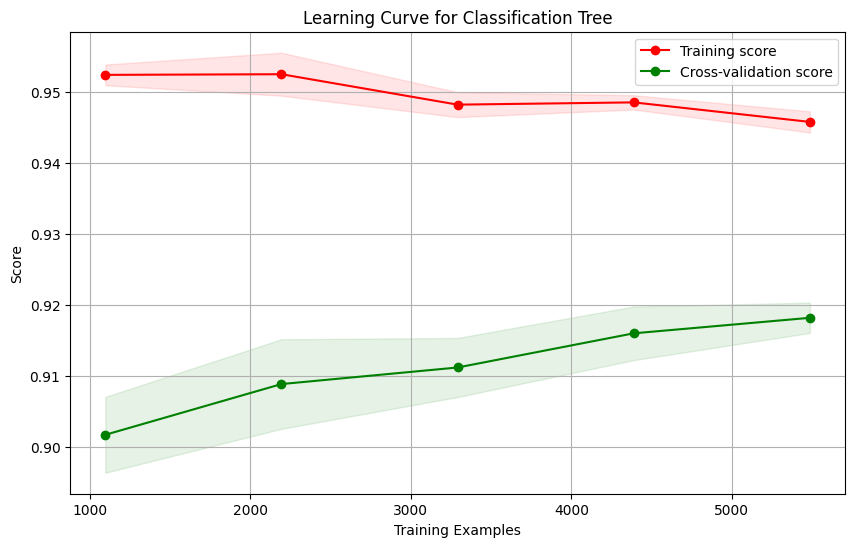

Accuracy:0.9068241469816273
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      1098
           1       0.94      0.88      0.91      1188

    accuracy                           0.91      2286
   macro avg       0.91      0.91      0.91      2286
weighted avg       0.91      0.91      0.91      2286



In [50]:
# Classification Tree for URL based features
classification_tree_metrics_external = classification_tree(x_train_external, x_dev_external, y_train_external, y_dev_external)
for key, value in classification_tree_metrics_external.items():
    print(f"{key}{value}")

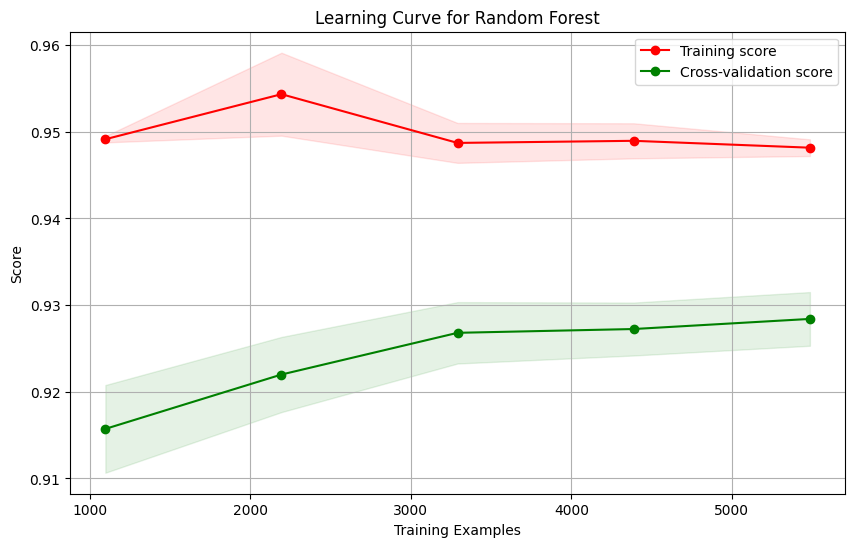

Accuracy:0.9243219597550306
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1098
           1       0.94      0.92      0.93      1188

    accuracy                           0.92      2286
   macro avg       0.92      0.92      0.92      2286
weighted avg       0.92      0.92      0.92      2286



In [51]:
# Random Forest for URL based features
random_forest_metrics_external = random_forest(x_train_external, x_dev_external, y_train_external, y_dev_external)
for key, value in random_forest_metrics_external.items():
    print(f"{key}{value}")

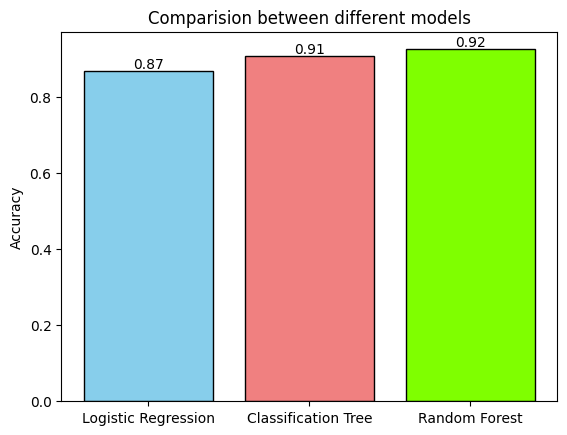

In [52]:
#Plot a bar graph comparing the accuracy for all three models
plot_comparision_graph(*[metrics['Accuracy:'] for metrics in [log_reg_metrics_external, 
                                                              classification_tree_metrics_external, random_forest_metrics_external]])

In [53]:
accuracy_comparision.update({"External Based":(log_reg_metrics_external['Accuracy:'],classification_tree_metrics_external['Accuracy:'],random_forest_metrics_external['Accuracy:'])})

### EXPLORATORY DATA ANALYSIS ###

**HANDLING NUMERICAL VARIABLES**

**CREATING A SUBSET OF NUMERICAL FEATURES**

In [54]:
# List containing all the names of the numerical features
numerical_features = ['length_url', 'length_hostname', 'nb_dots', 'nb_hyphens','nb_at', 'nb_qm', 'nb_and', 
                   'nb_or', 'nb_eq', 'nb_underscore','nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 
                   'nb_comma','nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com','nb_dslash',"http_in_path",'ratio_digits_url','ratio_digits_host', 
                    'nb_subdomains','nb_redirection', 'nb_external_redirection','length_words_raw', 'char_repeat', 
                    'shortest_words_raw','shortest_word_host', 'shortest_word_path', 'longest_words_raw','longest_word_host', 
                    'longest_word_path','avg_words_raw','avg_word_host', 'avg_word_path', 'phish_hints', 'nb_hyperlinks',
                   'ratio_intHyperlinks','ratio_extHyperlinks', 'ratio_nullHyperlinks', 'nb_extCSS','ratio_intRedirection', 'ratio_extRedirection',
                   'ratio_intErrors','ratio_extErrors', 'links_in_tags', 'ratio_intMedia', 'ratio_extMedia', 'safe_anchor',
                   'domain_registration_length', 'domain_age','web_traffic','page_rank']

In [55]:
#Creating a new dataset containing all the numerical features. 
df_continuous = train_set[numerical_features]
#Checking the dimension of the dataset containing only numerical features.
df_continuous.shape

(6858, 57)

**PLOTTING CONTINUOUS FEATURES BEFORE SCALING AND REMOVING LOW VARIANCE FEATURES USING HISTOGRAMS AND BOXPLOTS**

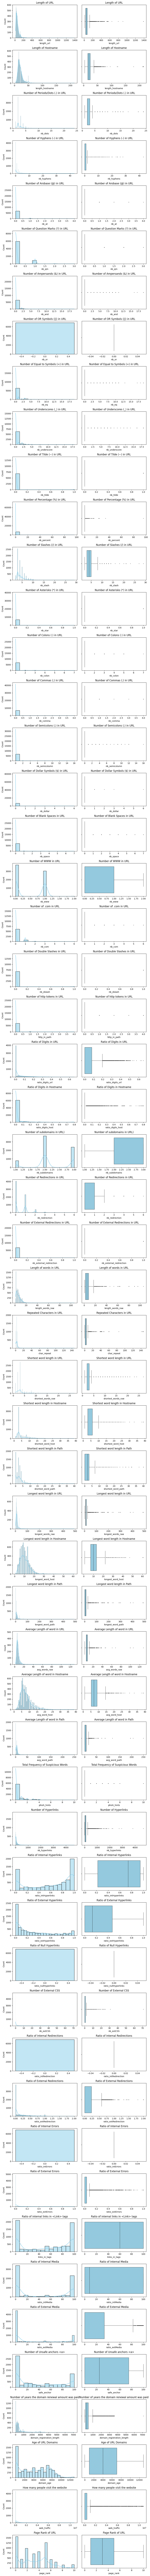

In [56]:
#Plotting numerical variables after removing 0 variance features but without any further processing
plot_hist_box(df_continuous, 'skyblue')

**SCALE FEATURES USING LOG TRANSFORMATION AND MIN-MAX SCALING**

In [57]:
# Log transform and scale
shifted_df = df_continuous + np.abs(df_continuous.min()) + 1e-5
df_transformed = np.log1p(shifted_df)
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = pd.DataFrame(scaler.fit_transform(df_transformed), 
                         columns=df_transformed.columns, 
                         index=df_transformed.index)  # Preserve indices

**REMOVE FEATURES WITH LOW OR ZERO VARIANCE AND APPLY SCALING**

In [58]:
# Apply VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
df_low_var = selector.fit_transform(df_scaled)
df_low_var = pd.DataFrame(df_low_var, 
                          columns=df_scaled.columns[selector.get_support()], 
                          index=df_scaled.index)  # Preserve indices
df_low_var.shape

(6858, 40)

In [59]:
# Compare dataframes and store the features that are not present in reduced dataframe when compared to df_continuous in a list.
missing_cols = df_continuous.columns.difference(df_low_var.columns).tolist()

#Reviewing the variance of removed features from the previous step. 
for i in missing_cols:
    print(f"Column {i} - variance: {df_scaled[i].var()}")

Column avg_words_raw - variance: 0.00677578980839691
Column http_in_path - variance: 0.003666438315529141
Column nb_at - variance: 0.004222854260270317
Column nb_colon - variance: 0.0029579208684690135
Column nb_comma - variance: 0.0009203929289275154
Column nb_dollar - variance: 0.00032161200972877875
Column nb_dslash - variance: 0.006519574800852969
Column nb_external_redirection - variance: 0.0029082213734026503
Column nb_or - variance: 0.0
Column nb_percent - variance: 0.003019289911496805
Column nb_semicolumn - variance: 0.004142010069355765
Column nb_space - variance: 0.0038054496740591247
Column nb_star - variance: 0.0008742526842887523
Column nb_tilde - variance: 0.0072386557144359645
Column ratio_intErrors - variance: 0.0
Column ratio_intRedirection - variance: 0.0
Column ratio_nullHyperlinks - variance: 0.0


**PLOTTING CONTINUOUS FEATURES AFTER SCALING AND REMOVING LOW VARIANCE FEATURES USING HISTOGRAMS AND BOXPLOTS**

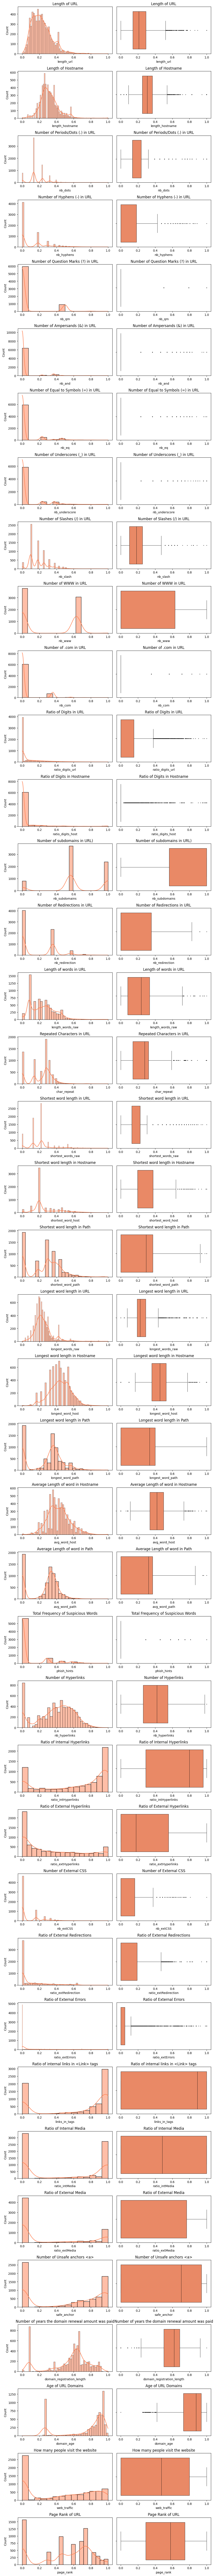

In [60]:
#Plotting numerical variables after feature sclaing and removing low variance features
plot_hist_box(df_low_var, 'coral')

**HANDLING CATEGORICAL VARIABLES**

**CREATING A SUBSET OF CATEGORICAL FEATURES**

In [61]:
#Creating a new dataset containing all the categorical features without the dependent variable. 
temp_list = numerical_features + ['status_encoded']
df_categorical = train_set.drop(labels = temp_list, axis = 'columns', inplace = False)
#Checking the dimension of the dataset containing only categorical features.
df_categorical.shape

(6858, 30)

In [62]:
# Check if indices are misaligned after opeations on and removal of categorical features. No output means all is well.
assert (df_categorical.index == df_low_var.index).all(), "Indices are misaligned!"

**REMOVE FEATURES WITH CONSTANT VALUES**

In [63]:
#Removing categorical features whose values remain constant throughout the dataset such as submit_email. 

redundant_features = []
# Iterate over each column (feature) to check for constant values
for column in df_categorical.columns:
    # Check for uniform values
    if df_categorical[column].max() == df_categorical[column].min():
        redundant_features.append(column)
print(f"Categorical features with a constant value: {', '.join(redundant_features)}")

#Drop identified features
df_categorical = df_categorical.drop(labels = redundant_features, axis = 'columns', inplace = False)
#Verify dimension of dataset after removal
df_categorical.shape

Categorical features with a constant value: submit_email, sfh


(6858, 28)

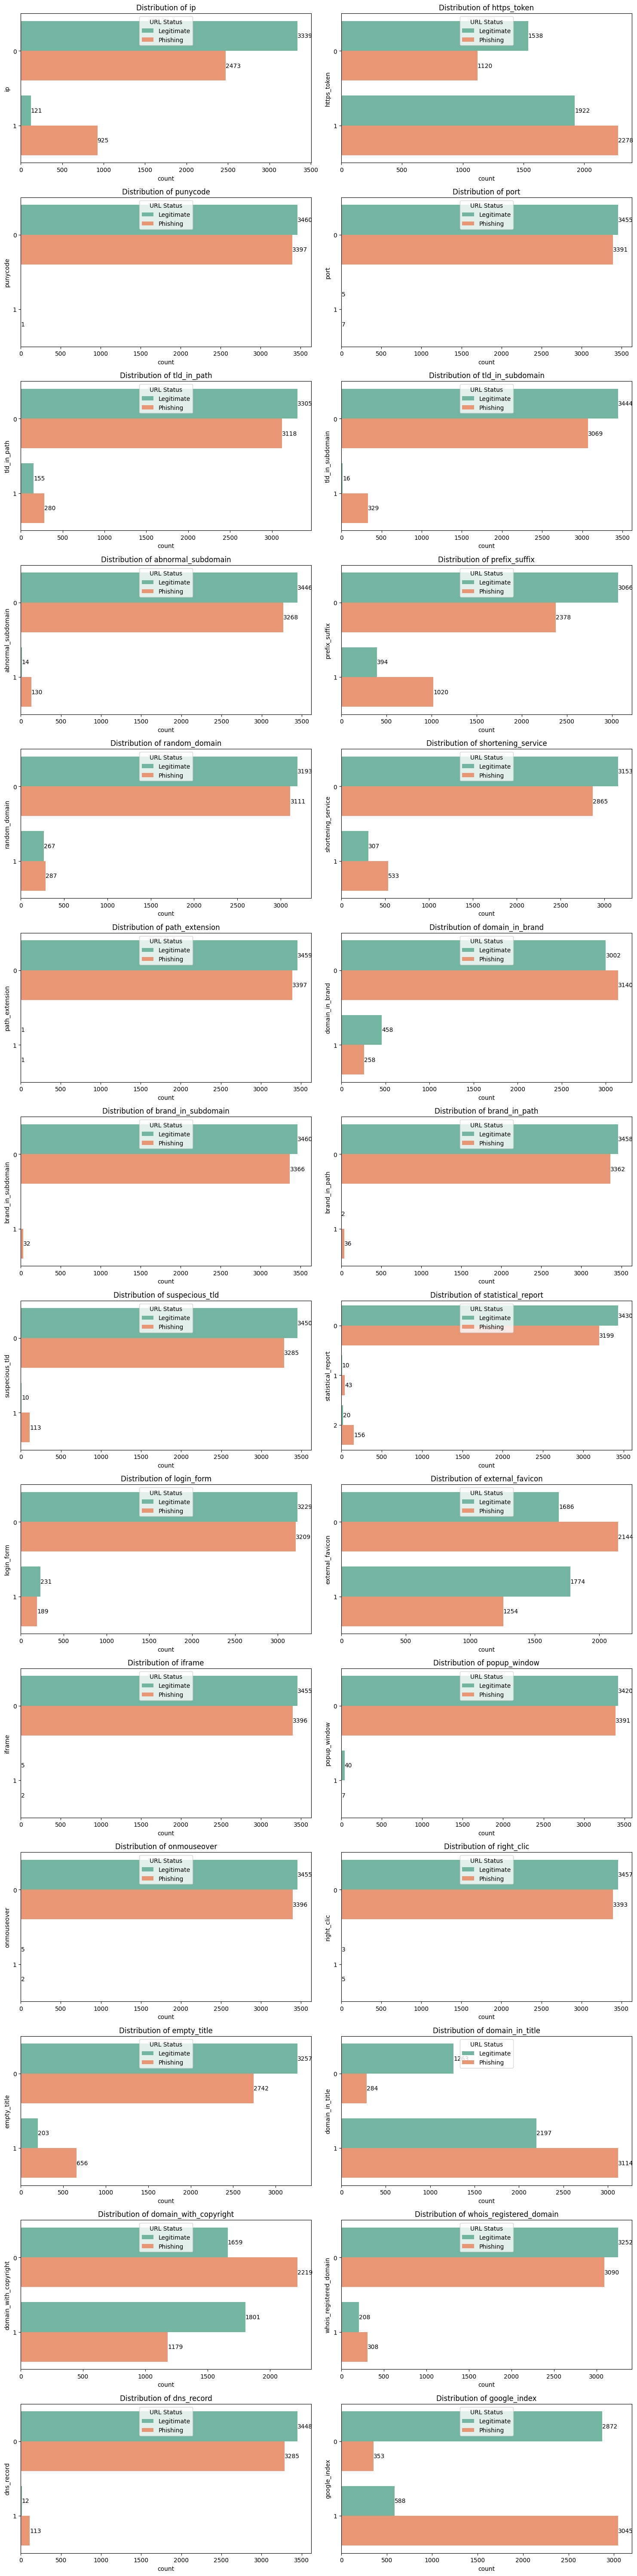

In [64]:
#Plotting categorical variables after removing constant valued features but without any further processing
count_plot(df_categorical,train_set)

**FILTER TO REMOVE HIGHLY IMBALANCED CATEGORICAL FEATURES.**

In [65]:
#Inspecting some unusual features - features which seem to be highly imbalanced.
print(f"Total datapoints where 'punycode' = 1: {df_categorical[df_categorical['port'] == 1].shape[0]}; Total datapoints where 'punycode' = 0: {df_categorical[df_categorical['port'] == 0].shape[0]}")

Total datapoints where 'punycode' = 1: 12; Total datapoints where 'punycode' = 0: 6846


In [66]:
#Filter function to remove highly imbalanced categorical features
# Iterate over each column to check for uniform or highly imbalanced features (>= 90%)
# If 90% of the values are similar i.e., say out of 10k datapoints, 9k have the same value for feature x
redundant_features = []
for column in df_categorical.columns:
    value_counts = df_categorical[column].value_counts(normalize=True)
    if value_counts.min() < 0.1:  # If any category is less than 10% of total
        redundant_features.append(column)
redundant_features

['punycode',
 'port',
 'tld_in_path',
 'tld_in_subdomain',
 'abnormal_subdomain',
 'random_domain',
 'path_extension',
 'brand_in_subdomain',
 'brand_in_path',
 'suspecious_tld',
 'statistical_report',
 'login_form',
 'iframe',
 'popup_window',
 'onmouseover',
 'right_clic',
 'whois_registered_domain',
 'dns_record']

In [67]:
#Drop identified features
df_categorical = df_categorical.drop(labels = redundant_features, axis = 'columns', inplace = False)
#Verify dimension of dataset after removal
df_categorical.shape

(6858, 10)

In [68]:
# Check if indices are misaligned after opeations on and removal of categorical features. No output means all is well.
assert (df_categorical.index == df_low_var.index).all(), "Indices are misaligned!"

In [69]:
df_processed = pd.concat([df_low_var, df_categorical], axis = 1)
df_processed.shape

(6858, 50)

In [70]:
# Check if new dataframe contains any null values. Do not include in report.
print(df_processed.isnull().sum())

length_url                    0
length_hostname               0
nb_dots                       0
nb_hyphens                    0
nb_qm                         0
nb_and                        0
nb_eq                         0
nb_underscore                 0
nb_slash                      0
nb_www                        0
nb_com                        0
ratio_digits_url              0
ratio_digits_host             0
nb_subdomains                 0
nb_redirection                0
length_words_raw              0
char_repeat                   0
shortest_words_raw            0
shortest_word_host            0
shortest_word_path            0
longest_words_raw             0
longest_word_host             0
longest_word_path             0
avg_word_host                 0
avg_word_path                 0
phish_hints                   0
nb_hyperlinks                 0
ratio_intHyperlinks           0
ratio_extHyperlinks           0
nb_extCSS                     0
ratio_extRedirection          0
ratio_ex

**APPLY LOG TRANSFORMATION AND MIN MAX SCALING TO DEVELOPMENT SET**

In [71]:
# Save the list of columns retained in df_low_var (after VarianceThreshold)
selected_columns = df_low_var.columns.tolist()

# Now scale the dev set
df_dev_continuous = dev_set[numerical_features]  # Similar to what was done for the training set

# Log transform and scale (apply the same transformation as the training set)
shifted_dev = df_dev_continuous + np.abs(df_dev_continuous.min()) + 1e-5
df_dev_transformed = np.log1p(shifted_dev)

# Apply MinMax scaling using the same scaler that was used in the training set
df_dev_scaled = pd.DataFrame(scaler.transform(df_dev_transformed), 
                             columns=df_dev_transformed.columns, 
                             index=df_dev_transformed.index)  # Preserve indices

# Select only the features that were kept in the training set
df_dev_scaled = df_dev_scaled[selected_columns]

# Now df_dev_scaled has to be combined with other categorical features in the development

df_dev_categorical = dev_set[df_categorical.columns]
dev_set_processed = pd.concat([df_dev_scaled, df_dev_categorical], axis = 1)

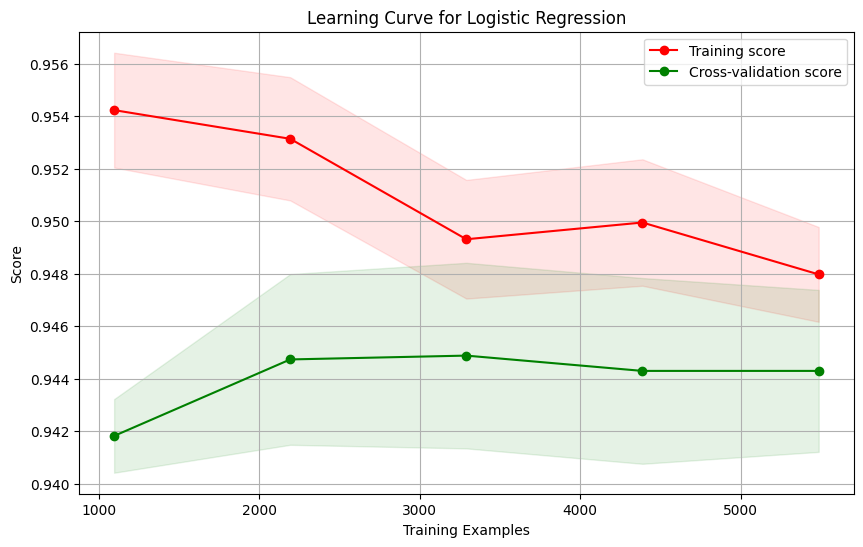

Accuracy::
0.937007874015748
Classification Report:
:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1098
           1       0.94      0.93      0.94      1188

    accuracy                           0.94      2286
   macro avg       0.94      0.94      0.94      2286
weighted avg       0.94      0.94      0.94      2286



In [72]:
log_reg_metrics_scaled = logistic_regression(df_processed, dev_set_processed, y_train, y_dev)
for key, value in log_reg_metrics_scaled.items():
    print(f"{key}:\n{value}")

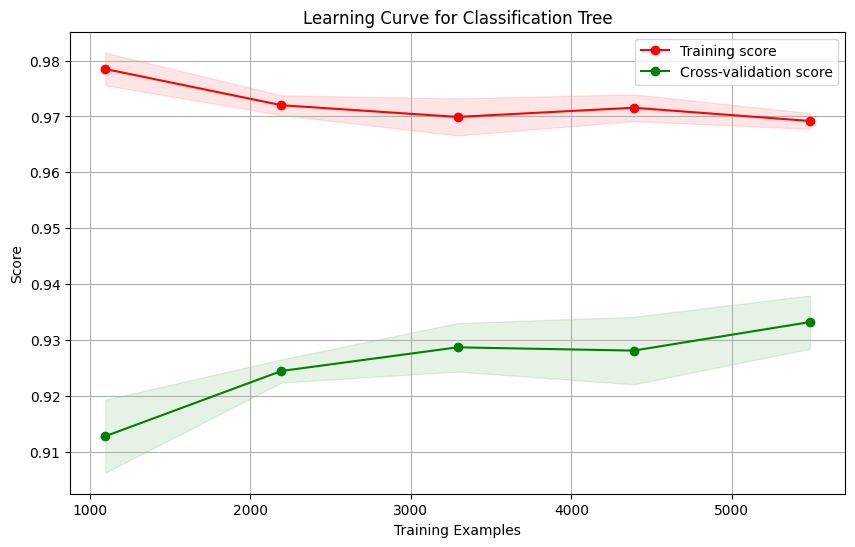

Accuracy:0.9238845144356955
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1098
           1       0.94      0.91      0.93      1188

    accuracy                           0.92      2286
   macro avg       0.92      0.92      0.92      2286
weighted avg       0.92      0.92      0.92      2286



In [73]:
classification_tree_metrics_scaled = classification_tree(df_processed, dev_set_processed, y_train, y_dev)
for key, value in classification_tree_metrics_scaled.items():
    print(f"{key}{value}")

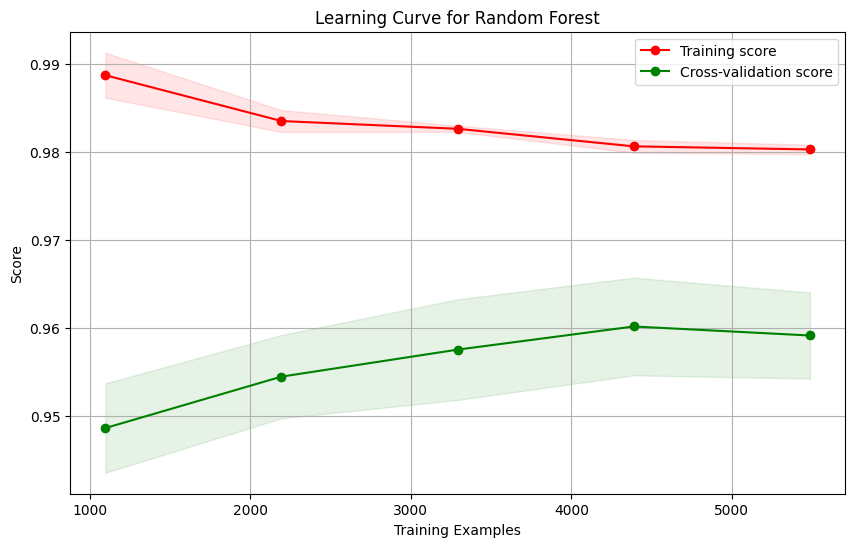

Accuracy:0.9518810148731408
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1098
           1       0.96      0.95      0.95      1188

    accuracy                           0.95      2286
   macro avg       0.95      0.95      0.95      2286
weighted avg       0.95      0.95      0.95      2286



In [74]:
random_forest_metrics_scaled = random_forest(df_processed, dev_set_processed, y_train, y_dev)
for key, value in random_forest_metrics_scaled.items():
    print(f"{key}{value}")

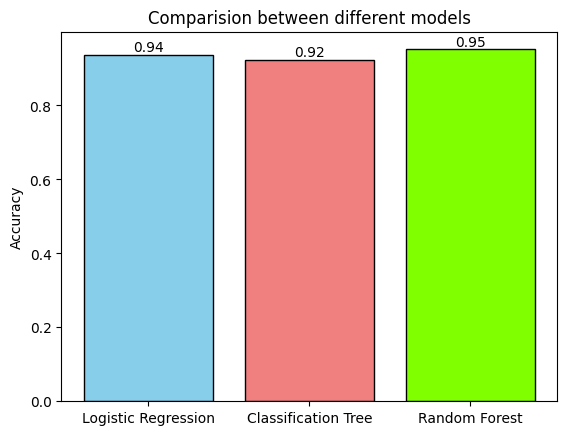

In [75]:
#Plot a bar graph comparing the accuracy for all three models
plot_comparision_graph(*[metrics['Accuracy:'] for metrics in [log_reg_metrics_scaled, classification_tree_metrics_scaled, random_forest_metrics_scaled]])

In [76]:
accuracy_comparision.update({"EDA":(log_reg_metrics_scaled['Accuracy:'],classification_tree_metrics_scaled['Accuracy:'],random_forest_metrics_scaled['Accuracy:'])})

**PEARSON CORRELATION**

<Axes: >

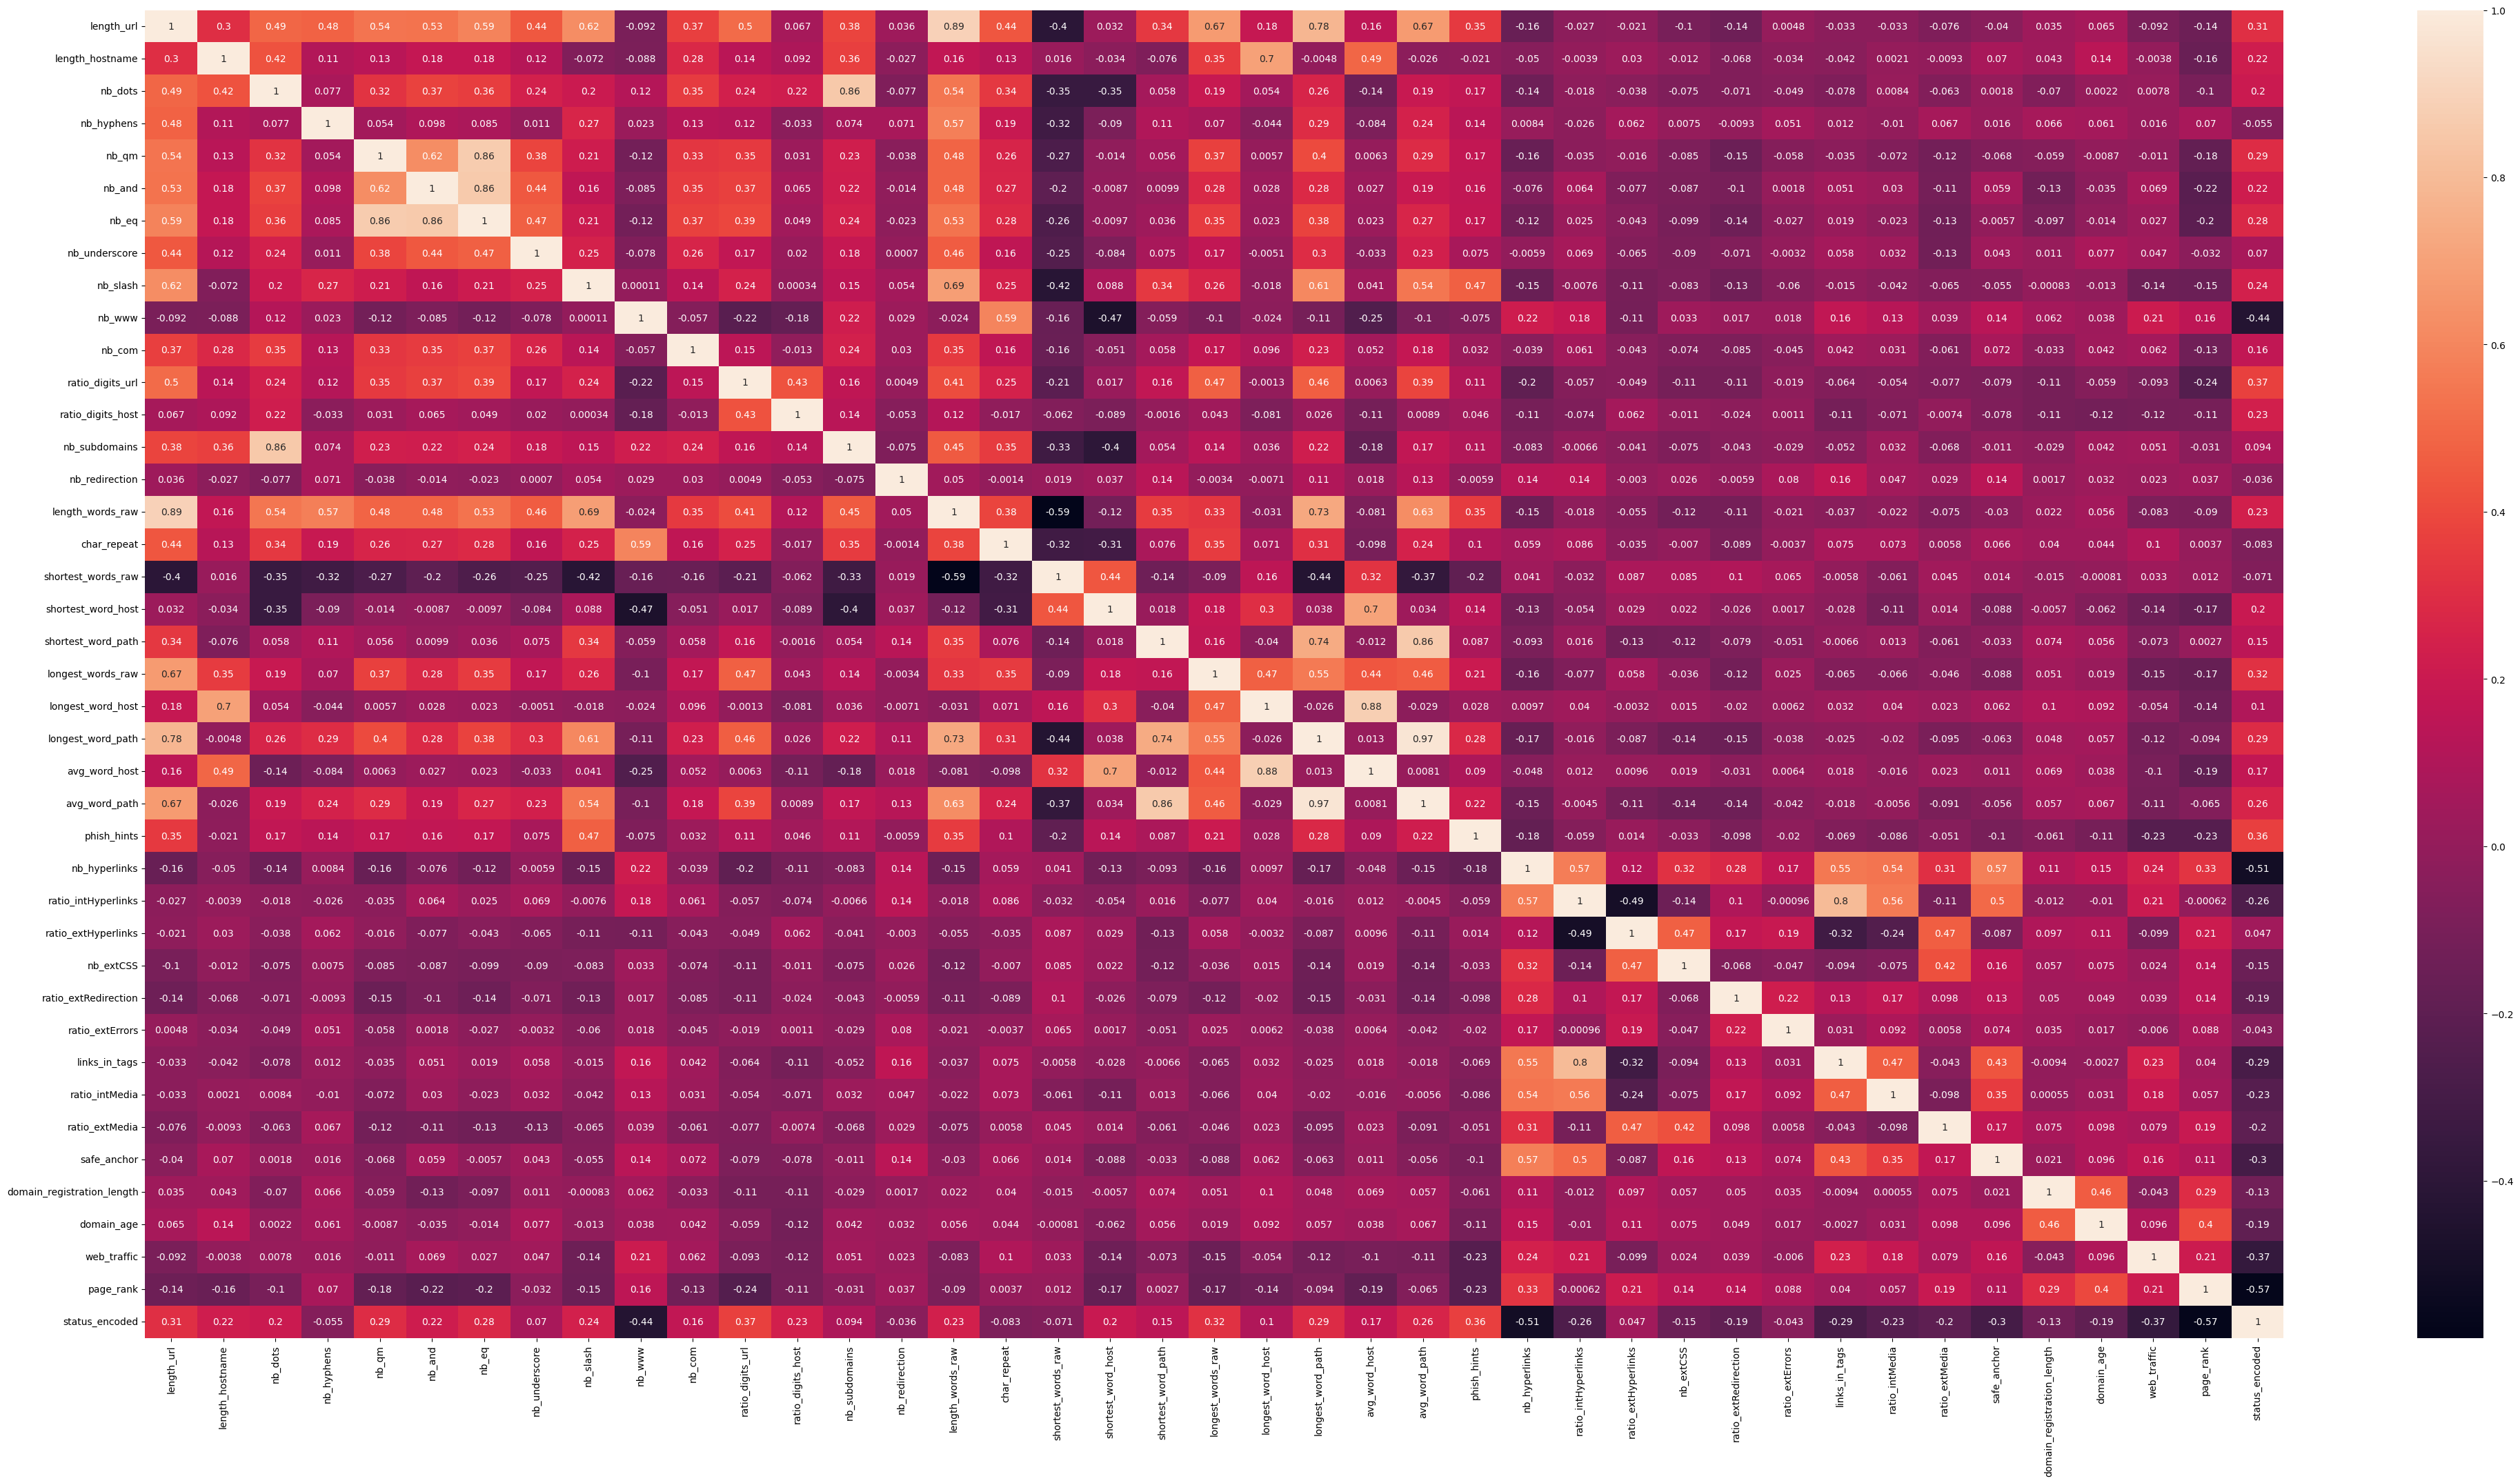

In [77]:
# Plot a Correlation Heatmap between all the numerical variables and the target variable

temp = df_low_var
temp['status_encoded'] = train_set['status_encoded']
correlation_df = temp.corr()
plt.figure(figsize = (50,25))
sns.heatmap(correlation_df, annot=True, annot_kws=dict(size=10))

In [78]:
# Identify the most correlated feature, with a correlation of 0.85 or higher. Check function definition above.

correlated_features = find_correlated_features(df_low_var, 0.85)
for items in correlated_features:
    print(f"{items[0]} - {items[1]}")

length_url - length_words_raw
nb_dots - nb_subdomains
nb_qm - nb_eq
nb_and - nb_eq
shortest_word_path - avg_word_path
longest_word_host - avg_word_host
longest_word_path - avg_word_path


In [79]:
# Drop the set of features that are highly correlated with each other to prevent multicollinearity.
drop_features = []
for item in correlated_features:
    drop_features.append(item[1])

# In this instance, we see that Count of '=' symbol is highly correlated with both count of '?' and count of '&'.
# However, this may always be not the case since these 3 symbols are individually independent. 
# Therefore removing '=' count would introduce a smaller degree of overfitting or loss of information.
# Thus we decide to keep all three features despite their high correlation.
drop_features = list(filter(('nb_eq').__ne__, drop_features))

print(drop_features)

['length_words_raw', 'nb_subdomains', 'avg_word_path', 'avg_word_host', 'avg_word_path']


In [80]:
# 'correlation_df' is a Pearson Correlation dataframe thus we also need to remove these features in the actual dataframe.
correlation_df = correlation_df.drop(labels = drop_features, axis = 'columns', inplace = False)
correlation_df = correlation_df.drop(drop_features)
# A new dataframe that only contains the features which are not correlated with each other.
df_multicollinearity = df_low_var.drop(labels = drop_features, axis = 'columns', inplace = False)
df_multicollinearity = df_multicollinearity.drop('status_encoded', axis = 'columns', inplace = False)

In [81]:
# Check to see if we successfully removed the rows and the columns from the correlation dataframe.
correlation_df.shape

(37, 37)

In [82]:
# Extract correlations for the target variable
target_variable = 'status_encoded'

# Select correlations with the target variable
target_corr = correlation_df[target_variable].drop(index=target_variable, errors='ignore')

# Convert to DataFrame for easier manipulation
target_corr = target_corr.to_frame(name="Correlation with Target")

# Sort correlations in descending order based on absolute values
target_corr = target_corr.reindex(target_corr["Correlation with Target"].abs().sort_values(ascending=False).index)

# Reset index so that feature names are in a column instead of being the index
target_corr = target_corr.reset_index().rename(columns={"index": "Feature"})

# Display the sorted correlations
print("Sorted correlations with the target variable:")
print(target_corr)

Sorted correlations with the target variable:
                       Feature  Correlation with Target
0                    page_rank                -0.570087
1                nb_hyperlinks                -0.513278
2                       nb_www                -0.435729
3             ratio_digits_url                 0.367685
4                  web_traffic                -0.366399
5                  phish_hints                 0.362804
6            longest_words_raw                 0.316806
7                   length_url                 0.306521
8                  safe_anchor                -0.301732
9                        nb_qm                 0.294256
10           longest_word_path                 0.292867
11               links_in_tags                -0.289562
12                       nb_eq                 0.275500
13         ratio_intHyperlinks                -0.263563
14                    nb_slash                 0.242509
15           ratio_digits_host                 0.232470
16

C:\Users\Anindya Chakravarty\AppData\Local\Temp\ipykernel_10704\1887690413.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


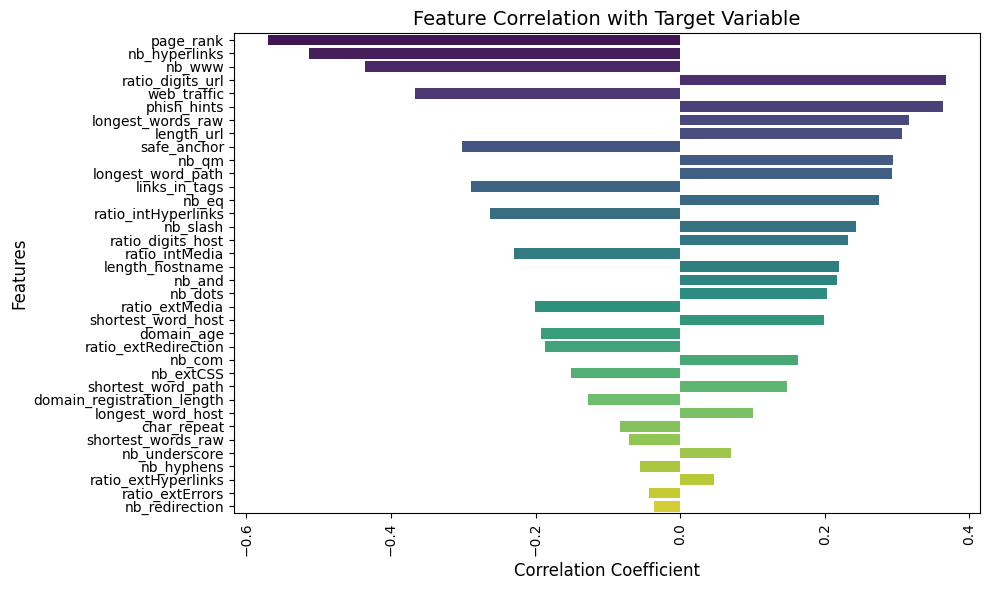

In [83]:
# Plot the correlations as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    x=target_corr["Correlation with Target"], 
    y=target_corr["Feature"], 
    palette="viridis"
)
plt.xticks(rotation=90)
plt.title("Feature Correlation with Target Variable", fontsize=14)
plt.xlabel("Correlation Coefficient", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

In [84]:
# Merge the continuous features with the categorical features after removing the correlated features from the continuous features subset.
# Now we will use this to run our models for training and inference.
train_set_pearson_correlation = pd.concat([df_multicollinearity, df_categorical], axis = 1)
train_set_pearson_correlation.shape

(6858, 46)

In [85]:
# Remove the same features from our dev set
dev_set_pearson_correlation = dev_set_processed.drop(drop_features, axis=1)

**RUN MODELLING ON THE DATASET WITHOUT THE INTER CORRELATED FEATURES**

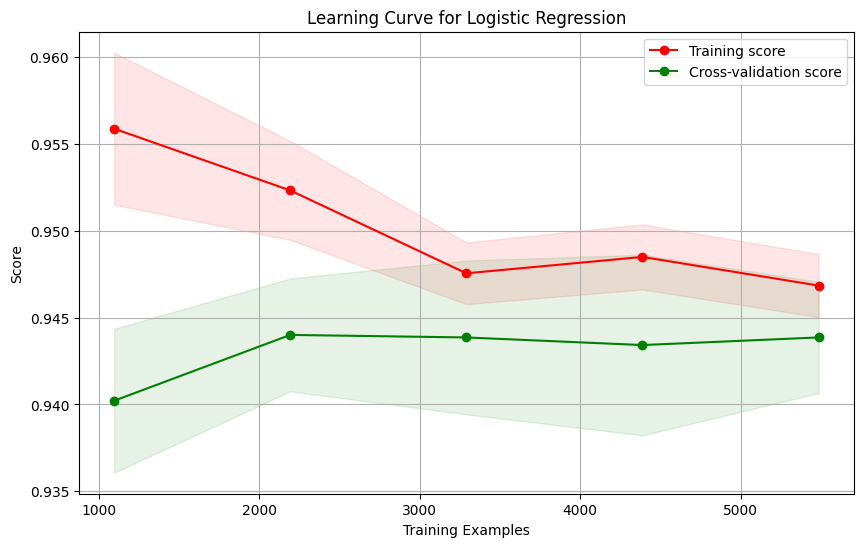

Accuracy::
0.9383202099737533
Classification Report:
:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1098
           1       0.95      0.94      0.94      1188

    accuracy                           0.94      2286
   macro avg       0.94      0.94      0.94      2286
weighted avg       0.94      0.94      0.94      2286



In [86]:
# Logistic Regression with scaled features and removed low variance features and 0 info gain values
log_reg_metrics_PC = logistic_regression(train_set_pearson_correlation, dev_set_pearson_correlation, y_train, y_dev)
for key, value in log_reg_metrics_PC.items():
    print(f"{key}:\n{value}")

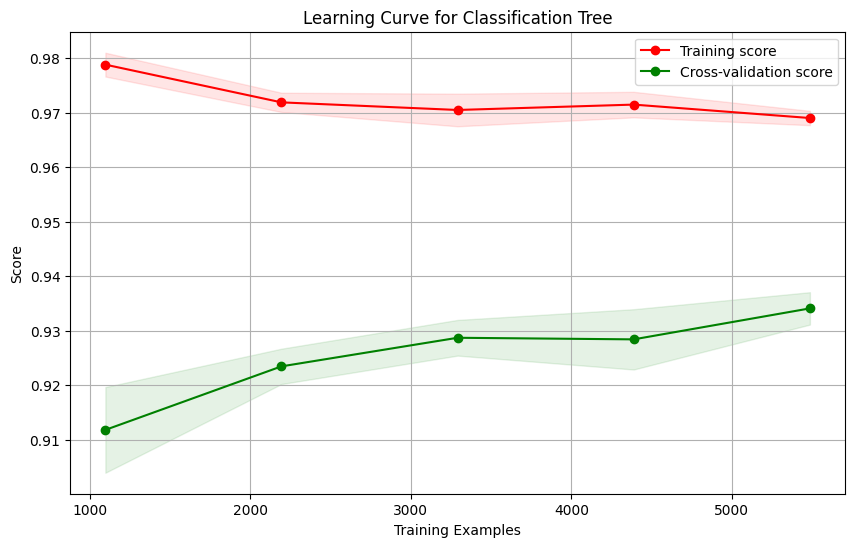

Accuracy:0.9203849518810149
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1098
           1       0.94      0.91      0.92      1188

    accuracy                           0.92      2286
   macro avg       0.92      0.92      0.92      2286
weighted avg       0.92      0.92      0.92      2286



In [87]:
# Classification Tree with scaled features and removed low variance features and 0 info gain values
classification_tree_metrics_PC = classification_tree(train_set_pearson_correlation, dev_set_pearson_correlation, y_train, y_dev)
for key, value in classification_tree_metrics_PC.items():
    print(f"{key}{value}")

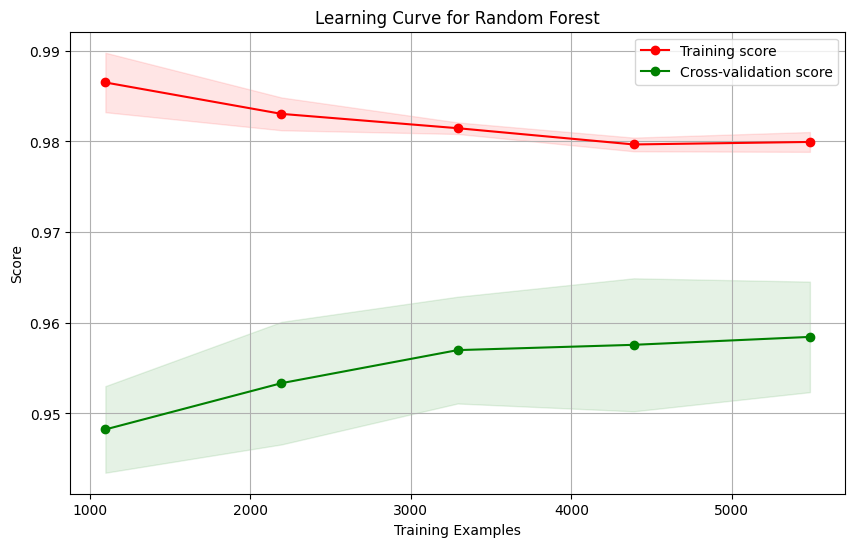

Accuracy:0.952755905511811
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1098
           1       0.96      0.95      0.95      1188

    accuracy                           0.95      2286
   macro avg       0.95      0.95      0.95      2286
weighted avg       0.95      0.95      0.95      2286



In [88]:
# Random Forest with scaled features and removed low variance features and 0 info gain values
random_forest_metrics_PC = random_forest(train_set_pearson_correlation, dev_set_pearson_correlation, y_train, y_dev)
for key, value in random_forest_metrics_PC.items():
    print(f"{key}{value}")

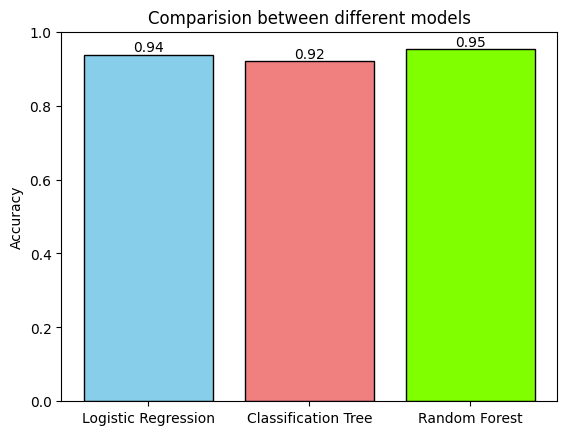

In [89]:
#Plot a bar graph comparing the accuracy for all three models
plot_comparision_graph(*[metrics['Accuracy:'] for metrics in [log_reg_metrics_PC, classification_tree_metrics_PC, random_forest_metrics_PC]])

In [90]:
accuracy_comparision.update({"Pearson Correlation":(log_reg_metrics_PC['Accuracy:'],classification_tree_metrics_PC['Accuracy:'],random_forest_metrics_PC['Accuracy:'])})

**INFORMATION GAIN**

**NOTE:** The dataframe used for information gain is not influenced by our Pearson Correlation above, which means features that are correlated to each other are still present. This was done to observe how it rates the features that are correlated to each other.

In [91]:
#Calculate Information Gain to observe how features are ranked based on feature importance.

# Calculate mutual information
info_gain = mutual_info_classif(df_processed, y_train, discrete_features='auto', random_state=42)

# Create a DataFrame to view results
feature_importance = pd.DataFrame({
    'Feature': df_processed.columns,
    'Information_Gain': info_gain
}).sort_values(by='Information_Gain', ascending=False)

print(feature_importance)

                       Feature  Information_Gain
49                google_index          0.300151
38                 web_traffic          0.291304
37                  domain_age          0.264714
27         ratio_intHyperlinks          0.243143
28         ratio_extHyperlinks          0.239610
26               nb_hyperlinks          0.237082
39                   page_rank          0.214714
35                 safe_anchor          0.181355
36  domain_registration_length          0.145411
32               links_in_tags          0.113499
30        ratio_extRedirection          0.112731
22           longest_word_path          0.102301
9                       nb_www          0.100816
11            ratio_digits_url          0.092632
25                 phish_hints          0.086101
31             ratio_extErrors          0.084310
24               avg_word_path          0.084157
20           longest_words_raw          0.076273
33              ratio_intMedia          0.074859
0                   

In [92]:
# Show the Information Gain values of the features which are correlated with each other.
filtered_rows = feature_importance[feature_importance['Feature'].isin(drop_features)]
print(filtered_rows)

             Feature  Information_Gain
24     avg_word_path          0.084157
23     avg_word_host          0.071844
15  length_words_raw          0.045738
13     nb_subdomains          0.033331


In [93]:
# Function to plot a bar graph displaying all the values for information gain.

def information_gain_graph(df):
    fig, ax = plt.subplots(figsize=(35, 25))
    ax.bar(df['Feature'], df['Information_Gain'], color='skyblue',edgecolor = 'black')
    ax.set_xticklabels(df['Feature'], rotation=90)
    ax.set_ylabel('Information Gain')
    ax.set_title('Importance of Features based on Information Gain')
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}",  # Format height to 2 decimal places
                    (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom')
    plt.show()

C:\Users\Anindya Chakravarty\AppData\Local\Temp\ipykernel_10704\2329496982.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['Feature'], rotation=90)


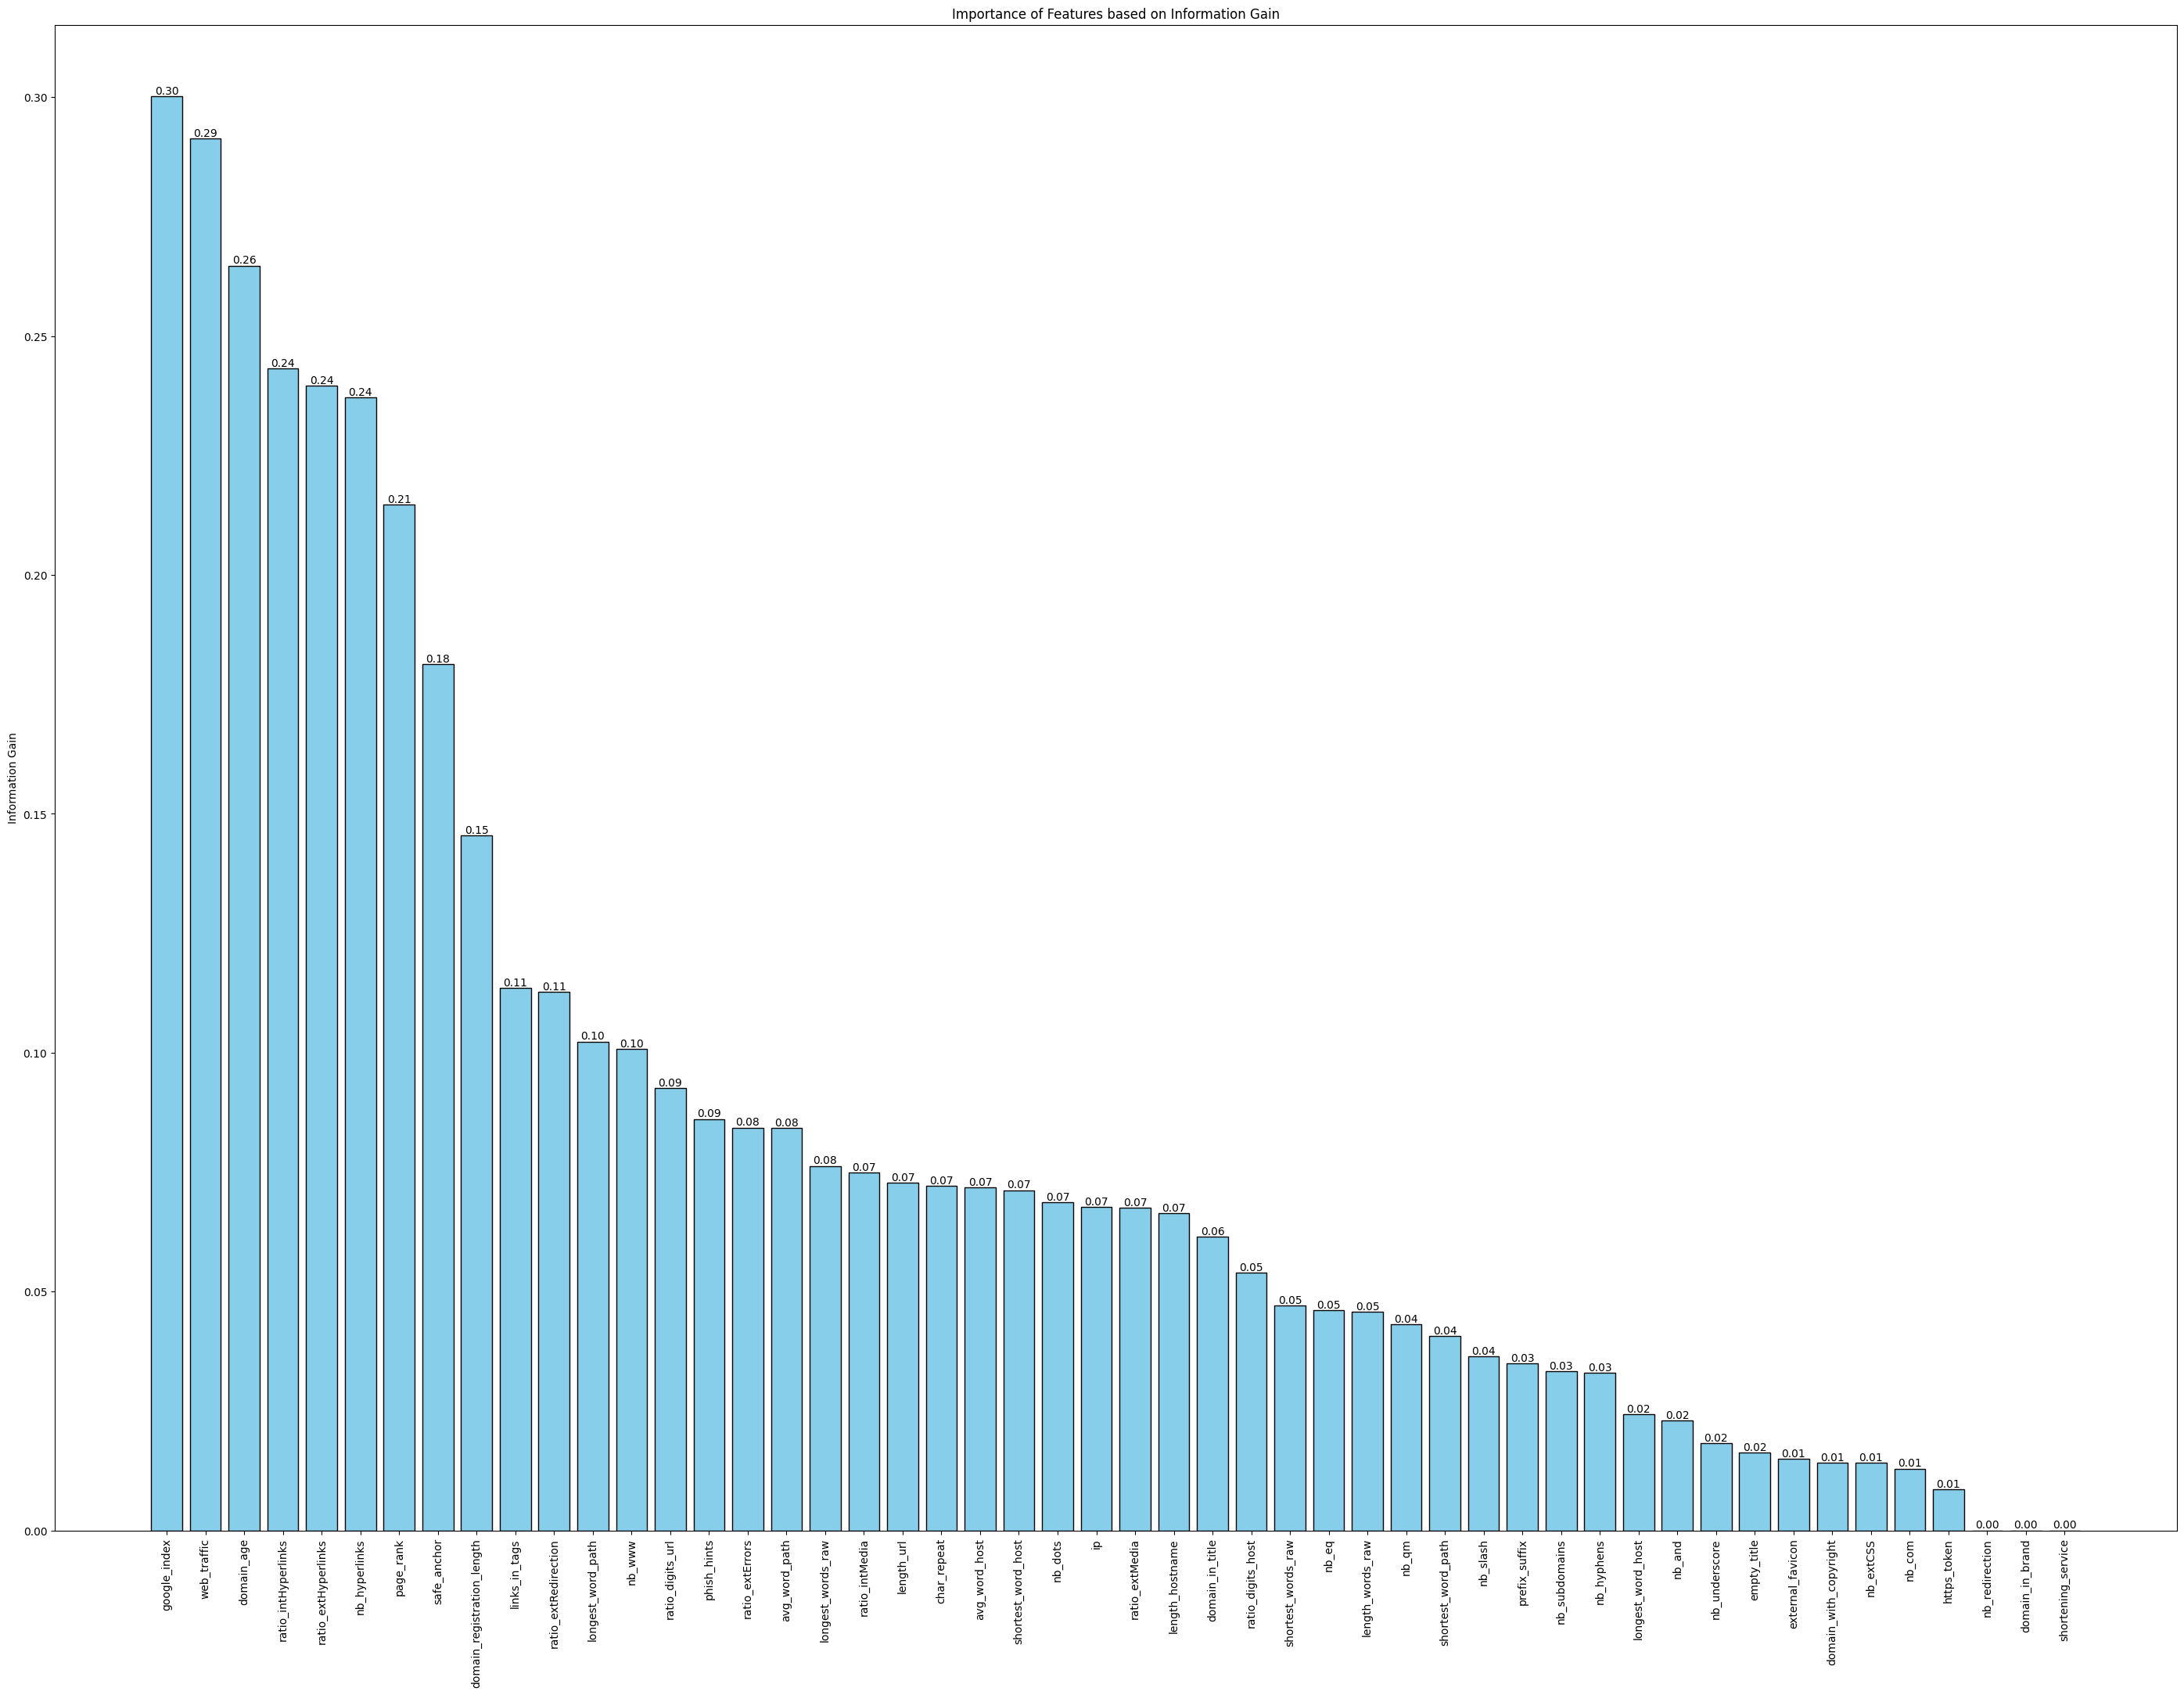

In [94]:
information_gain_graph(feature_importance)

**REMOVE THE FEATURES DEEMED UNNECESSARY BY INFORMATION GAIN AND TRAIN MODELS**

In [95]:
# List of features that we are removing based on Information Gain
feature_removal_list = ['nb_redirection','domain_in_brand','shortening_service']
train_set_info_gain = df_processed.drop(feature_removal_list, axis=1)
dev_set_info_gain = dev_set_processed.drop(feature_removal_list, axis=1)

In [96]:
train_set_info_gain.columns

Index(['length_url', 'length_hostname', 'nb_dots', 'nb_hyphens', 'nb_qm',
       'nb_and', 'nb_eq', 'nb_underscore', 'nb_slash', 'nb_www', 'nb_com',
       'ratio_digits_url', 'ratio_digits_host', 'nb_subdomains',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_word_host',
       'avg_word_path', 'phish_hints', 'nb_hyperlinks', 'ratio_intHyperlinks',
       'ratio_extHyperlinks', 'nb_extCSS', 'ratio_extRedirection',
       'ratio_extErrors', 'links_in_tags', 'ratio_intMedia', 'ratio_extMedia',
       'safe_anchor', 'domain_registration_length', 'domain_age',
       'web_traffic', 'page_rank', 'ip', 'https_token', 'prefix_suffix',
       'external_favicon', 'empty_title', 'domain_in_title',
       'domain_with_copyright', 'google_index'],
      dtype='object')

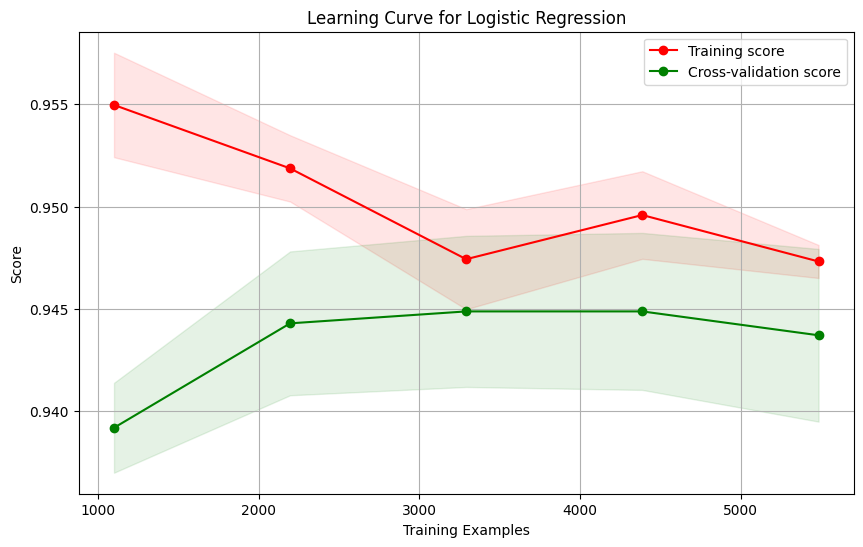

Accuracy::
0.9348206474190727
Classification Report:
:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1098
           1       0.94      0.93      0.94      1188

    accuracy                           0.93      2286
   macro avg       0.93      0.93      0.93      2286
weighted avg       0.93      0.93      0.93      2286



In [97]:
# Logistic Regression with scaled features and removed low variance features and 0 info gain values
log_reg_metrics_info_gain = logistic_regression(train_set_info_gain, dev_set_info_gain, y_train, y_dev)
for key, value in log_reg_metrics_info_gain.items():
    print(f"{key}:\n{value}")

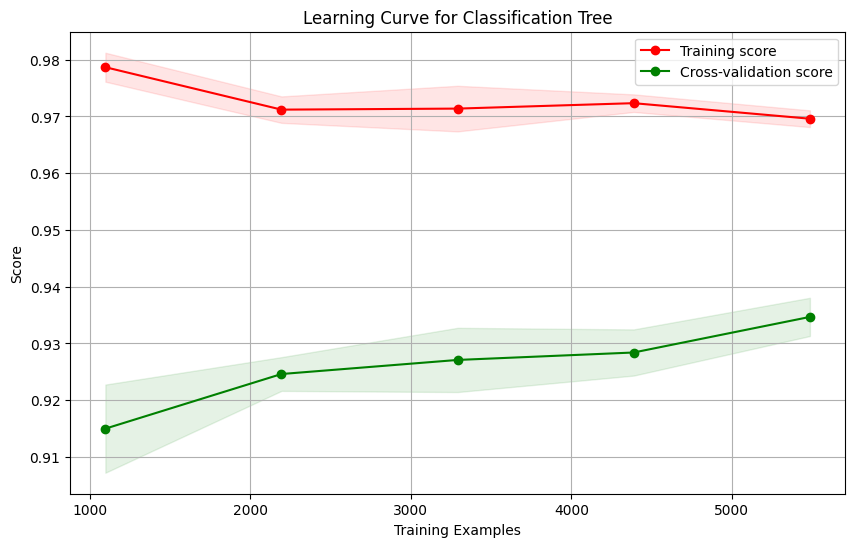

Accuracy:0.9221347331583553
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1098
           1       0.94      0.90      0.92      1188

    accuracy                           0.92      2286
   macro avg       0.92      0.92      0.92      2286
weighted avg       0.92      0.92      0.92      2286



In [98]:
# Classification Tree with scaled features and removed low variance features and 0 info gain values
classification_tree_metrics_info_gain = classification_tree(train_set_info_gain, dev_set_info_gain, y_train, y_dev)
for key, value in classification_tree_metrics_info_gain.items():
    print(f"{key}{value}")

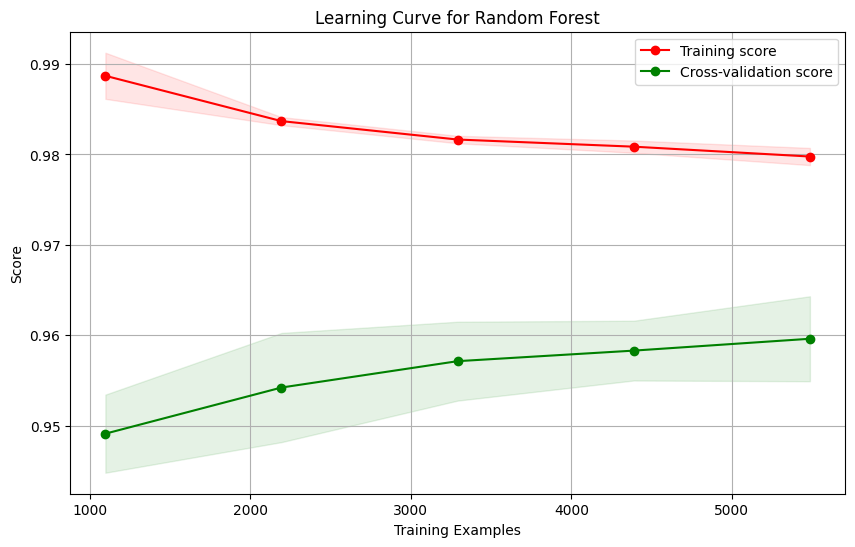

Accuracy:0.9531933508311461
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1098
           1       0.96      0.95      0.95      1188

    accuracy                           0.95      2286
   macro avg       0.95      0.95      0.95      2286
weighted avg       0.95      0.95      0.95      2286



In [99]:
# Random Forest with scaled features and removed low variance features and 0 info gain values
random_forest_metrics_info_gain = random_forest(train_set_info_gain, dev_set_info_gain, y_train, y_dev)
for key, value in random_forest_metrics_info_gain.items():
    print(f"{key}{value}")

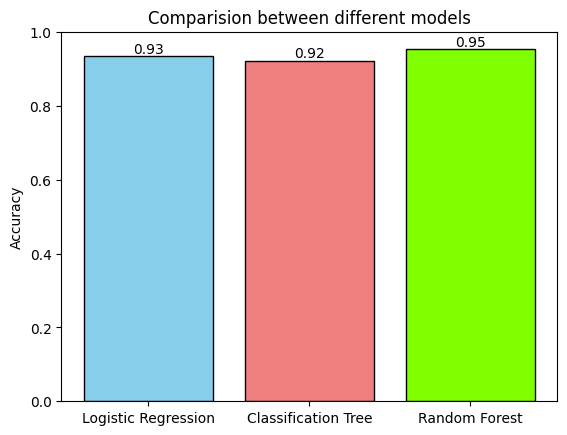

In [100]:
#Plot a bar graph comparing the accuracy for all three models
plot_comparision_graph(*[metrics['Accuracy:'] for metrics in [log_reg_metrics_info_gain, classification_tree_metrics_info_gain, random_forest_metrics_info_gain]])

In [101]:
accuracy_comparision.update({"Information Gain":(log_reg_metrics_info_gain['Accuracy:'],classification_tree_metrics_info_gain['Accuracy:'],random_forest_metrics_info_gain['Accuracy:'])})

**DISPLAY THE LEAST AND MOST IMPORTANT FEATURES ACCORDING TO PEARSON CORRELATION AND INFORMATION GAIN**

Sorted by Information Gain values in ascending order

In [102]:
# Merge the feature_importance and target_corr dataframes and only show the common features.
df_common = pd.merge(target_corr, feature_importance, on='Feature', how='inner')

# Sort the values based on Information Gain.
df_common = df_common.reindex(df_common['Information_Gain'].abs().sort_values(ascending=False).index)

print(df_common)

                       Feature  Correlation with Target  Information_Gain
4                  web_traffic                -0.366399          0.291304
22                  domain_age                -0.191830          0.264714
13         ratio_intHyperlinks                -0.263563          0.243143
33         ratio_extHyperlinks                 0.046900          0.239610
1                nb_hyperlinks                -0.513278          0.237082
0                    page_rank                -0.570087          0.214714
8                  safe_anchor                -0.301732          0.181355
27  domain_registration_length                -0.127676          0.145411
11               links_in_tags                -0.289562          0.113499
23        ratio_extRedirection                -0.187407          0.112731
10           longest_word_path                 0.292867          0.102301
2                       nb_www                -0.435729          0.100816
3             ratio_digits_url        

**BAR PLOT TO SHOW THE COMPARISION BETWEEN PEARSON CORRELATION AND INFORMATION GAIN**

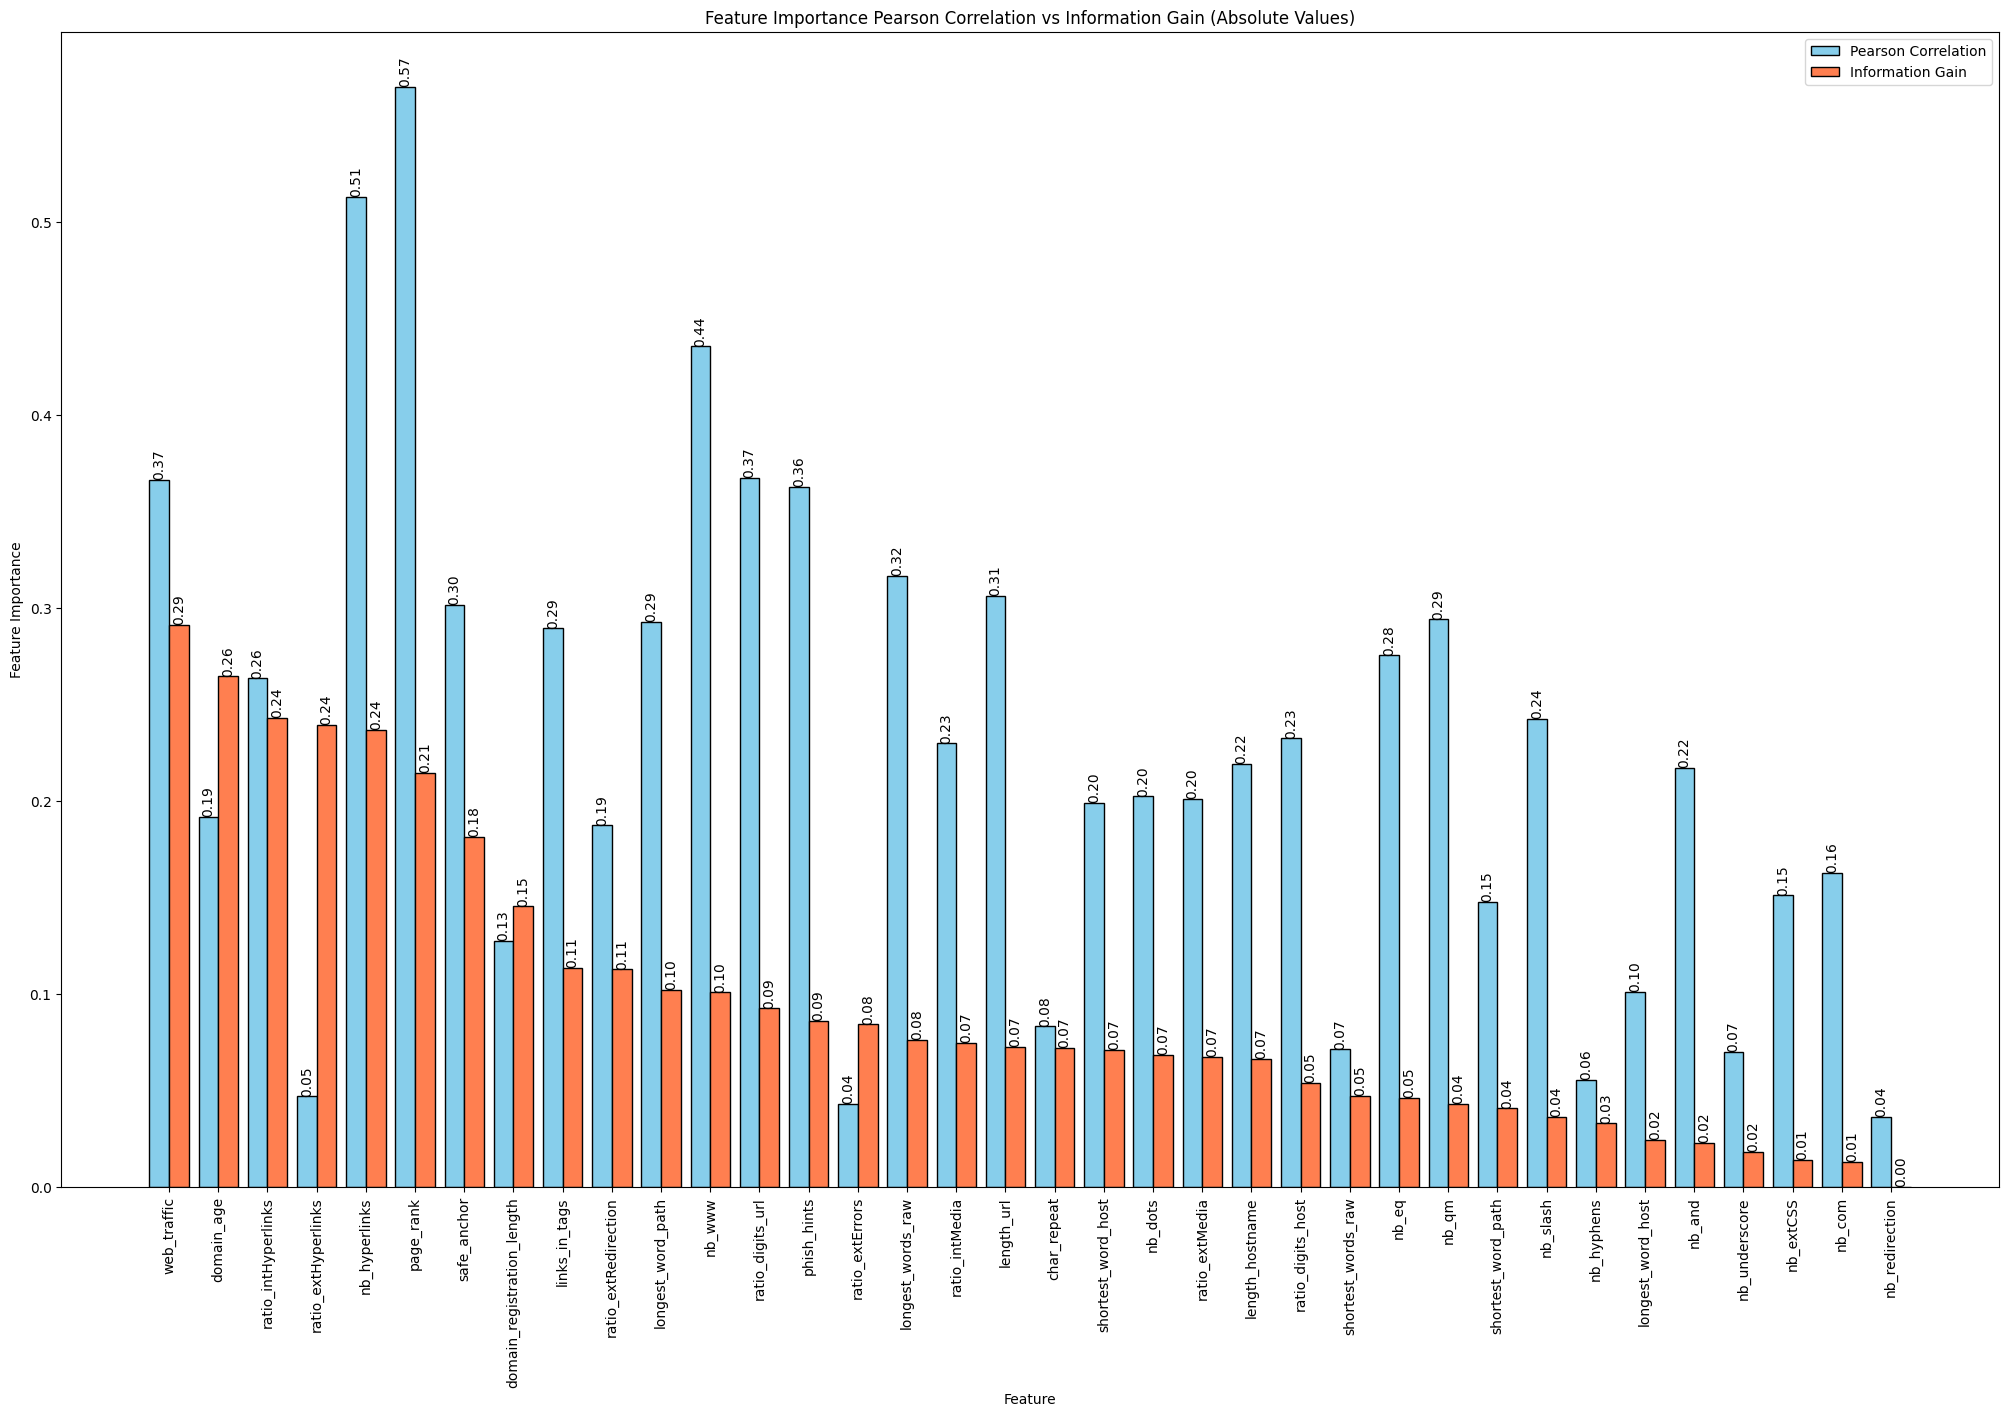

In [103]:
bar_width = 0.4
x = np.arange(len(df_common["Feature"]))
fig, ax = plt.subplots(figsize=(25,15))

ax.bar(x - bar_width/2, df_common["Correlation with Target"].abs(), width=bar_width, label="Pearson Correlation", color="skyblue", align='center', edgecolor = "black")
ax.bar(x + bar_width/2, df_common["Information_Gain"].abs(), width=bar_width, label="Information Gain", color="coral", align='center', edgecolor = "black")

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",  # Format height to 2 decimal places
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', rotation=90)

ax.set_xticks(x)
ax.set_xticklabels(df_common["Feature"], rotation=90)
ax.set_ylabel("Feature Importance")
ax.set_xlabel("Feature")
ax.set_title("Feature Importance Pearson Correlation vs Information Gain (Absolute Values)")
ax.legend()

# Display the plot
plt.show()

**REMOVE FEATURES SUGGESTED BY BOTH PEARSON CORRELATIONG (MULTICOLLINEARITY) AND INFORMATION GAIN TO TEST HOW MODELS PERFORM**

In [104]:
train_set_feature_imp = train_set_info_gain.drop(drop_features, axis=1, errors='ignore')
dev_set_feature_imp = dev_set_info_gain.drop(drop_features, axis=1, errors='ignore')

In [105]:
# DIAGNOSTICS - Checking to see if the columns from both methods were dropped successfully.

feature_imp_list = feature_removal_list + drop_features
print(feature_imp_list)
for item in feature_imp_list:
    if item in train_set_feature_imp.columns:
        print(item)
    else:
        print(f"{item} does not exist")

['nb_redirection', 'domain_in_brand', 'shortening_service', 'length_words_raw', 'nb_subdomains', 'avg_word_path', 'avg_word_host', 'avg_word_path']
nb_redirection does not exist
domain_in_brand does not exist
shortening_service does not exist
length_words_raw does not exist
nb_subdomains does not exist
avg_word_path does not exist
avg_word_host does not exist
avg_word_path does not exist


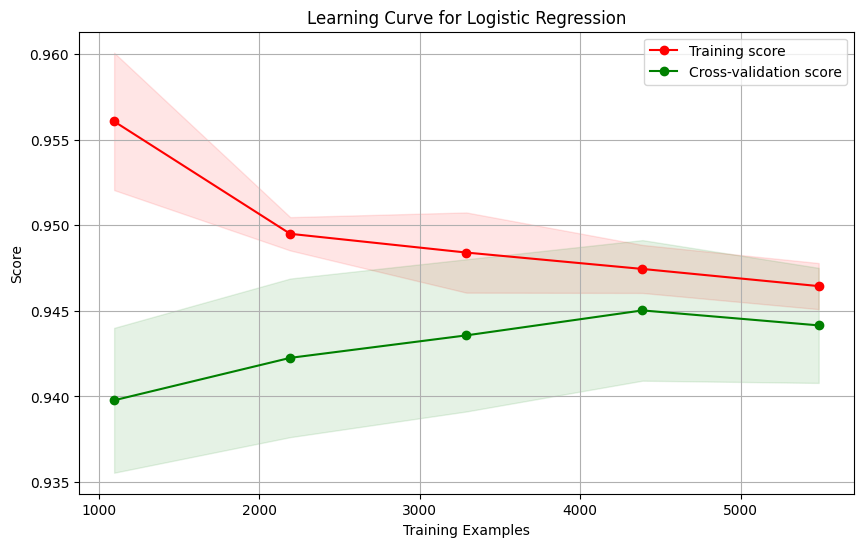

Accuracy::
0.9339457567804025
Classification Report:
:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1098
           1       0.94      0.93      0.94      1188

    accuracy                           0.93      2286
   macro avg       0.93      0.93      0.93      2286
weighted avg       0.93      0.93      0.93      2286



In [106]:
# Logistic Regression with L1 penalty, scaled features and removed low variance features
log_reg_metrics_feature_imp = logistic_regression(train_set_feature_imp, dev_set_feature_imp, y_train, y_dev)
for key, value in log_reg_metrics_feature_imp.items():
    print(f"{key}:\n{value}")

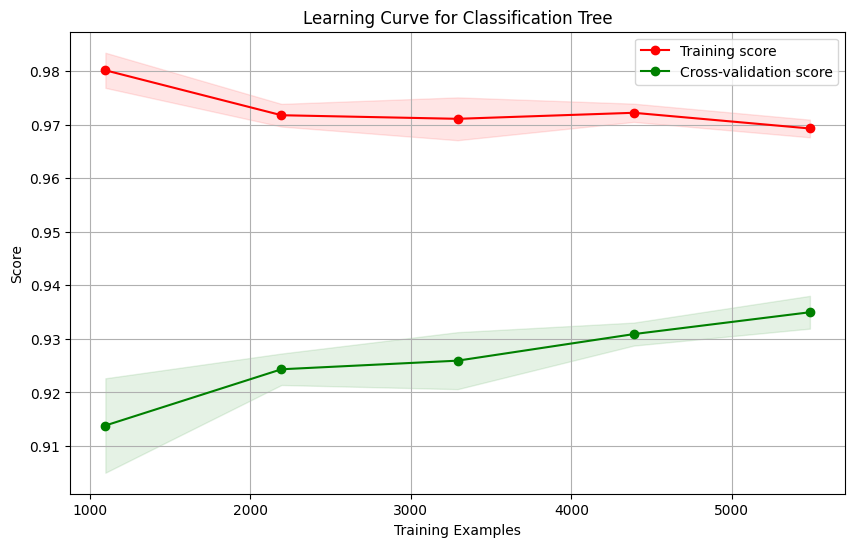

Accuracy:0.9203849518810149
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1098
           1       0.94      0.91      0.92      1188

    accuracy                           0.92      2286
   macro avg       0.92      0.92      0.92      2286
weighted avg       0.92      0.92      0.92      2286



In [107]:
# Classification Tree with scaled features and removed low variance features and 0 info gain values
classification_tree_metrics_feature_imp = classification_tree(train_set_feature_imp, dev_set_feature_imp, y_train, y_dev)
for key, value in classification_tree_metrics_feature_imp.items():
    print(f"{key}{value}")

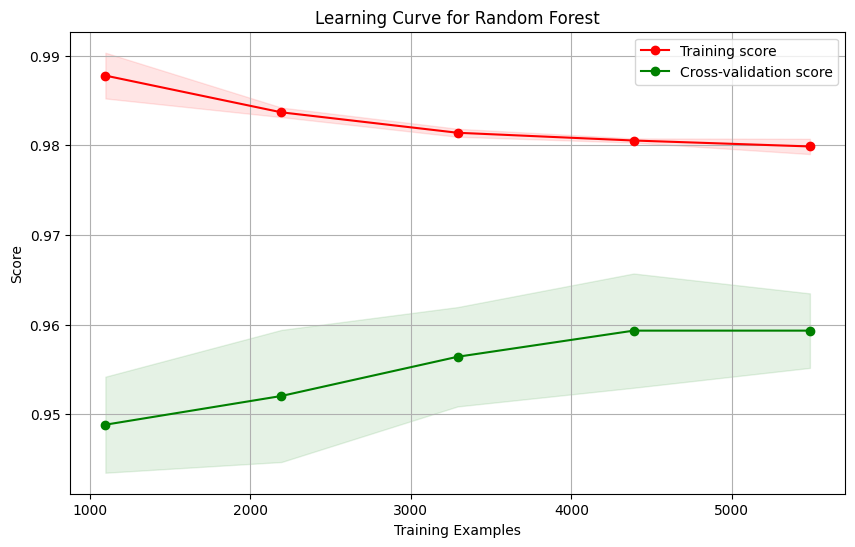

Accuracy:0.9518810148731408
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1098
           1       0.96      0.95      0.95      1188

    accuracy                           0.95      2286
   macro avg       0.95      0.95      0.95      2286
weighted avg       0.95      0.95      0.95      2286



In [108]:
# Random Forest with scaled features and removed low variance features and 0 info gain values
random_forest_metrics_feature_imp = random_forest(train_set_feature_imp, dev_set_feature_imp, y_train, y_dev)
for key, value in random_forest_metrics_feature_imp.items():
    print(f"{key}{value}")

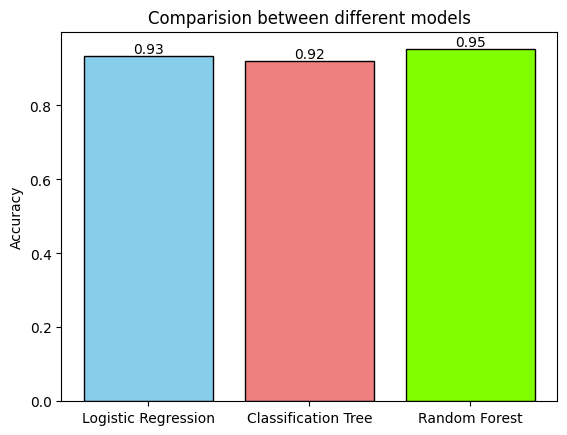

In [109]:
#Plot a bar graph comparing the accuracy for all three models
plot_comparision_graph(*[metrics['Accuracy:'] for metrics in [log_reg_metrics_feature_imp, classification_tree_metrics_feature_imp, random_forest_metrics_feature_imp]])

In [110]:
accuracy_comparision.update({"Information Gain \n&\n Pearson Correlation":(log_reg_metrics_feature_imp['Accuracy:'],classification_tree_metrics_feature_imp['Accuracy:'],random_forest_metrics_feature_imp['Accuracy:'])})

### RIDGE AND LASSO REGULARIZATION ###

**LASSO REGRESSION (L1 REGULARIZATION)**

In [111]:
# Function to plot bar graph to compare models
def plot_comparision_graph_2(eda_acc, noeda_acc, title):
    left_bar = title + " w/ EDA"
    right_bar = title + " w/o EDA"
    fig, ax = plt.subplots()
    ax.bar([left_bar, right_bar], [eda_acc, noeda_acc], 
           label=[left_bar, right_bar], color= ['skyblue','lightcoral'], edgecolor = 'black')
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}",  # Format height to 2 decimal places
                    (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom')
    ax.set_ylabel('Accuracy')
    ax.set_title('Comparision between different models')
    plt.show()

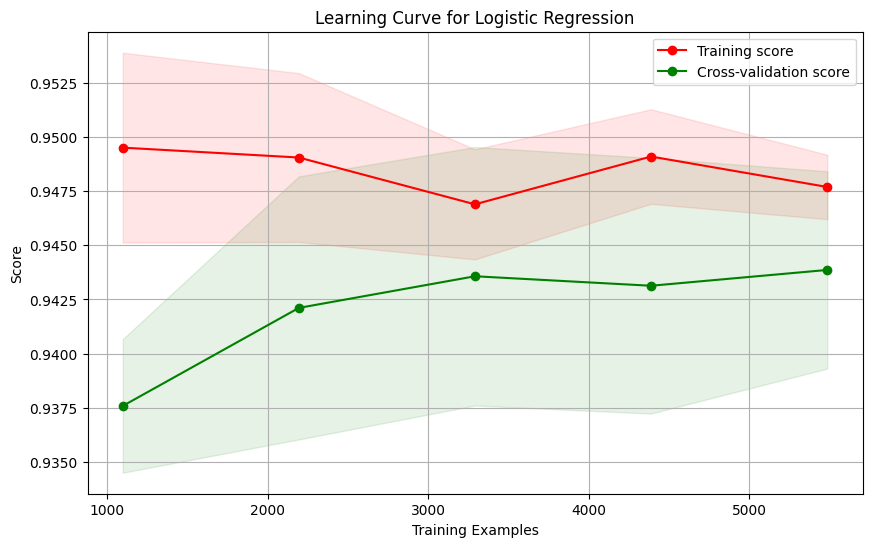

Accuracy::
0.9361329833770778
Classification Report:
:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1098
           1       0.94      0.93      0.94      1188

    accuracy                           0.94      2286
   macro avg       0.94      0.94      0.94      2286
weighted avg       0.94      0.94      0.94      2286



In [112]:
# Logistic Regression with L1 penalty, scaled features and removed low variance features
log_reg_metrics_l1 = logistic_regression(df_processed, dev_set_processed, y_train, y_dev, penalty='l1')
for key, value in log_reg_metrics_l1.items():
    print(f"{key}:\n{value}")

**LASSO (L1 REGULARIZATION) REGRESSION WITHOUT FEATURE SCALING OR REMOVING LOW VARIANCE/HIGHLY IMBALANCED FEATURES**

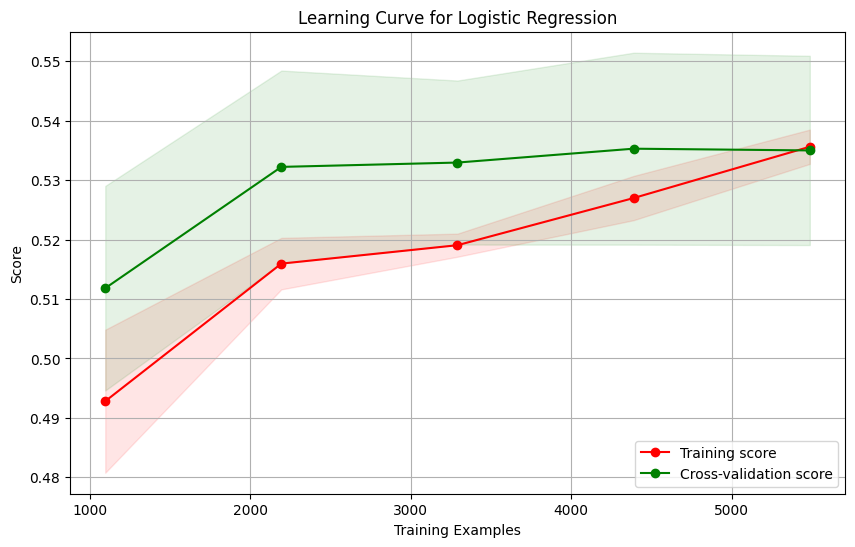

Accuracy::
0.520997375328084
Classification Report:
:
              precision    recall  f1-score   support

           0       0.50      0.85      0.63      1098
           1       0.61      0.22      0.32      1188

    accuracy                           0.52      2286
   macro avg       0.56      0.53      0.47      2286
weighted avg       0.56      0.52      0.47      2286



In [113]:
log_reg_metrics_l1_no_eda = logistic_regression(x_train, x_dev, y_train, y_dev, penalty='l1')
for key, value in log_reg_metrics_l1_no_eda.items():
    print(f"{key}:\n{value}")

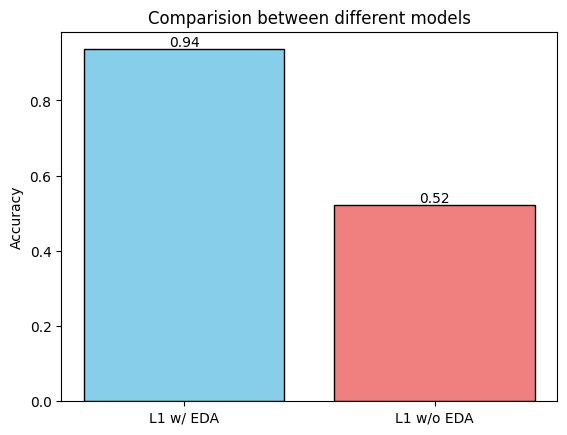

In [114]:
plot_comparision_graph_2(*[metrics['Accuracy:'] for metrics in [log_reg_metrics_l1, log_reg_metrics_l1_no_eda]], "L1")

**RIDGE REGRESSION (L2 REGULARIZATION)**

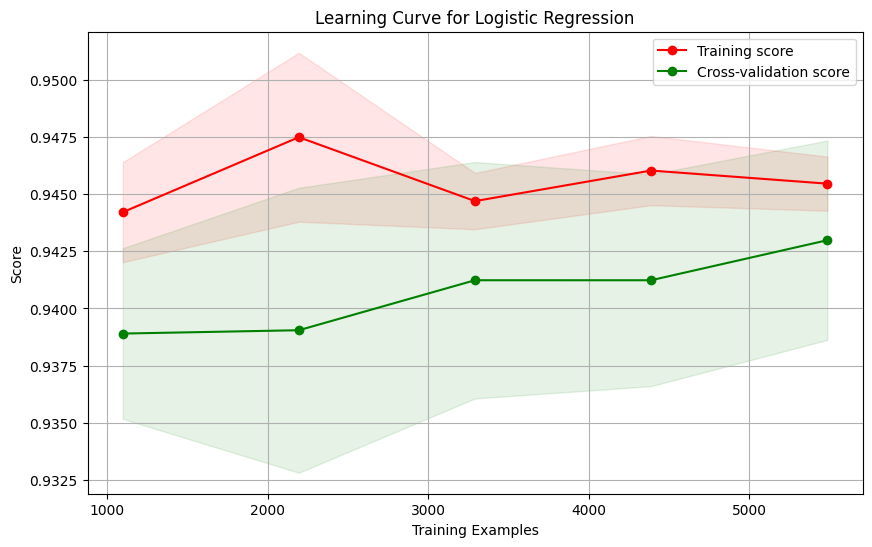

Accuracy::
0.9383202099737533
Classification Report:
:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1098
           1       0.95      0.93      0.94      1188

    accuracy                           0.94      2286
   macro avg       0.94      0.94      0.94      2286
weighted avg       0.94      0.94      0.94      2286



In [115]:
log_reg_metrics_l2 = logistic_regression(df_processed, dev_set_processed, y_train, y_dev, penalty='l2')
for key, value in log_reg_metrics_l2.items():
    print(f"{key}:\n{value}")

**RIDGE REGRESSION (L2 REGULARIZATION) WITHOUT FEATURE SCALING OR REMOVING LOW VARIANCE/HIGHLY IMBALANCED FEATURES**

C:\Users\Anindya Chakravarty\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


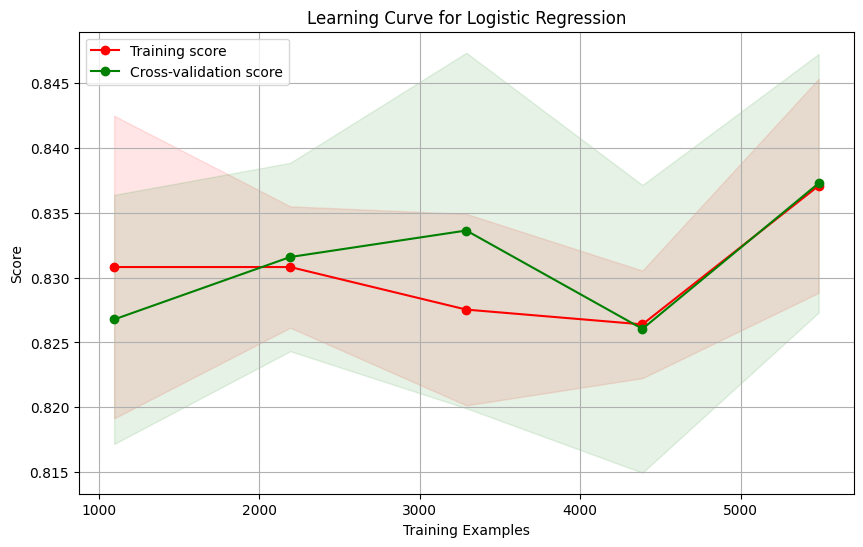

Accuracy::
0.836832895888014
Classification Report:
:
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1098
           1       0.87      0.81      0.84      1188

    accuracy                           0.84      2286
   macro avg       0.84      0.84      0.84      2286
weighted avg       0.84      0.84      0.84      2286



In [116]:
log_reg_metrics_l2_no_eda = logistic_regression(x_train, x_dev, y_train, y_dev, penalty='l2')
for key, value in log_reg_metrics_l2_no_eda.items():
    print(f"{key}:\n{value}")

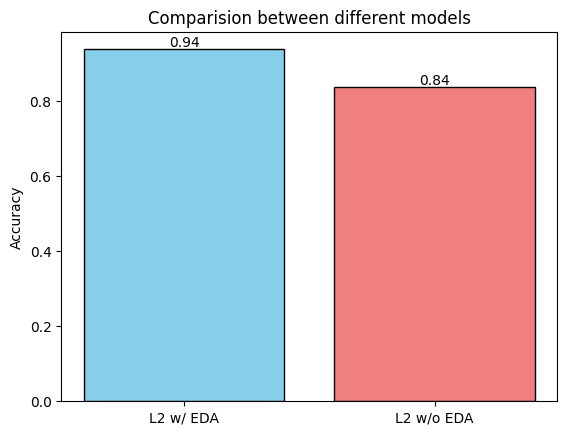

In [117]:
plot_comparision_graph_2(*[metrics['Accuracy:'] for metrics in [log_reg_metrics_l2, log_reg_metrics_l2_no_eda]], "L2")

### MODEL PERFORMANCE COMPARISION ###

**Let us plot the accuracies of all 3 models in each scenario which we tested to gain a clear understanding**

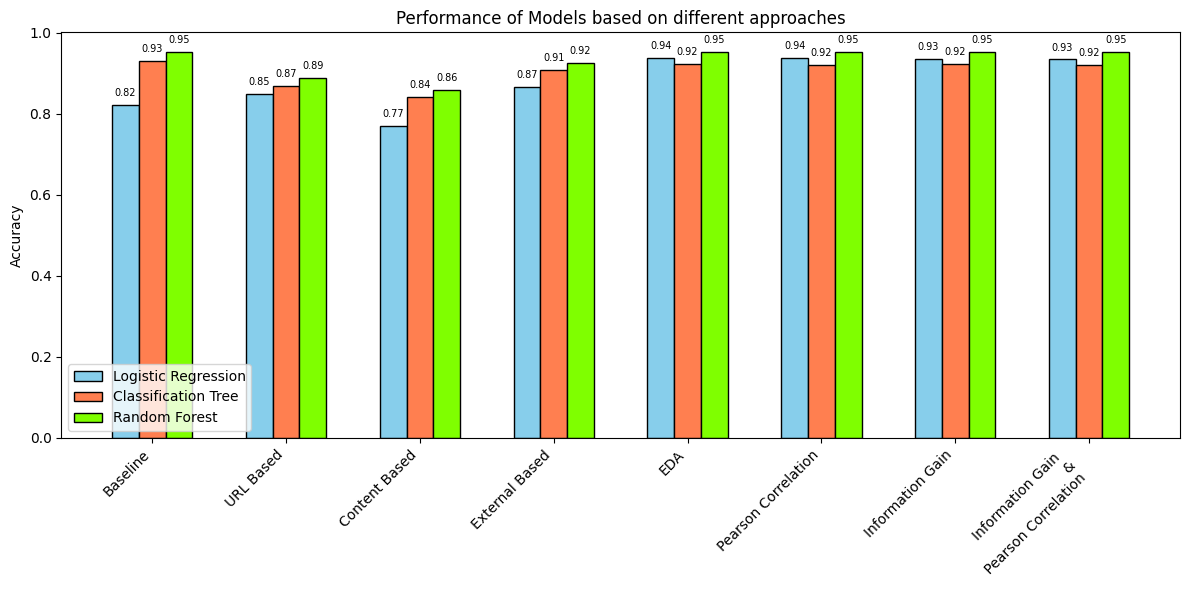

In [118]:
labels = list(accuracy_comparision.keys())
values = np.array(list(accuracy_comparision.values()))  # Convert to NumPy array for easy manipulation

# Number of bars per group
num_groups = values.shape[1]  # 3 values per key
bar_width = 0.2  # Adjust width for spacing
x = np.arange(len(labels))  # X locations for groups

# Colors for each metric
colors = ["skyblue", "coral", "chartreuse"]
metrics = ["Logistic Regression", "Classification Tree", "Random Forest"]  # Customize these names if needed

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each set of values
bars = []
for i in range(num_groups):
    bars.append(ax.bar(x + i * bar_width - bar_width, values[:, i], width=bar_width, 
                       label=metrics[i], color=colors[i], edgecolor="black"))

# Add annotations for bar values
for bar_group in bars:  # Iterate through each model's bars
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}",  # Format height to 2 decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),  # Position at the center top
                    xytext=(0, 5),  # Offset for clarity
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=7)  # Rotate text vertically

# Labeling
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')  # Rotate labels for better visibility
ax.set_ylabel("Accuracy")
ax.set_title("Performance of Models based on different approaches")
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


## COMPARING THE COEFFICIENTS OF LOGISTIC REGRESSION TO SEE HOW ARE OPERATIONS AFFECT THINGS ##

C:\Users\Anindya Chakravarty\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


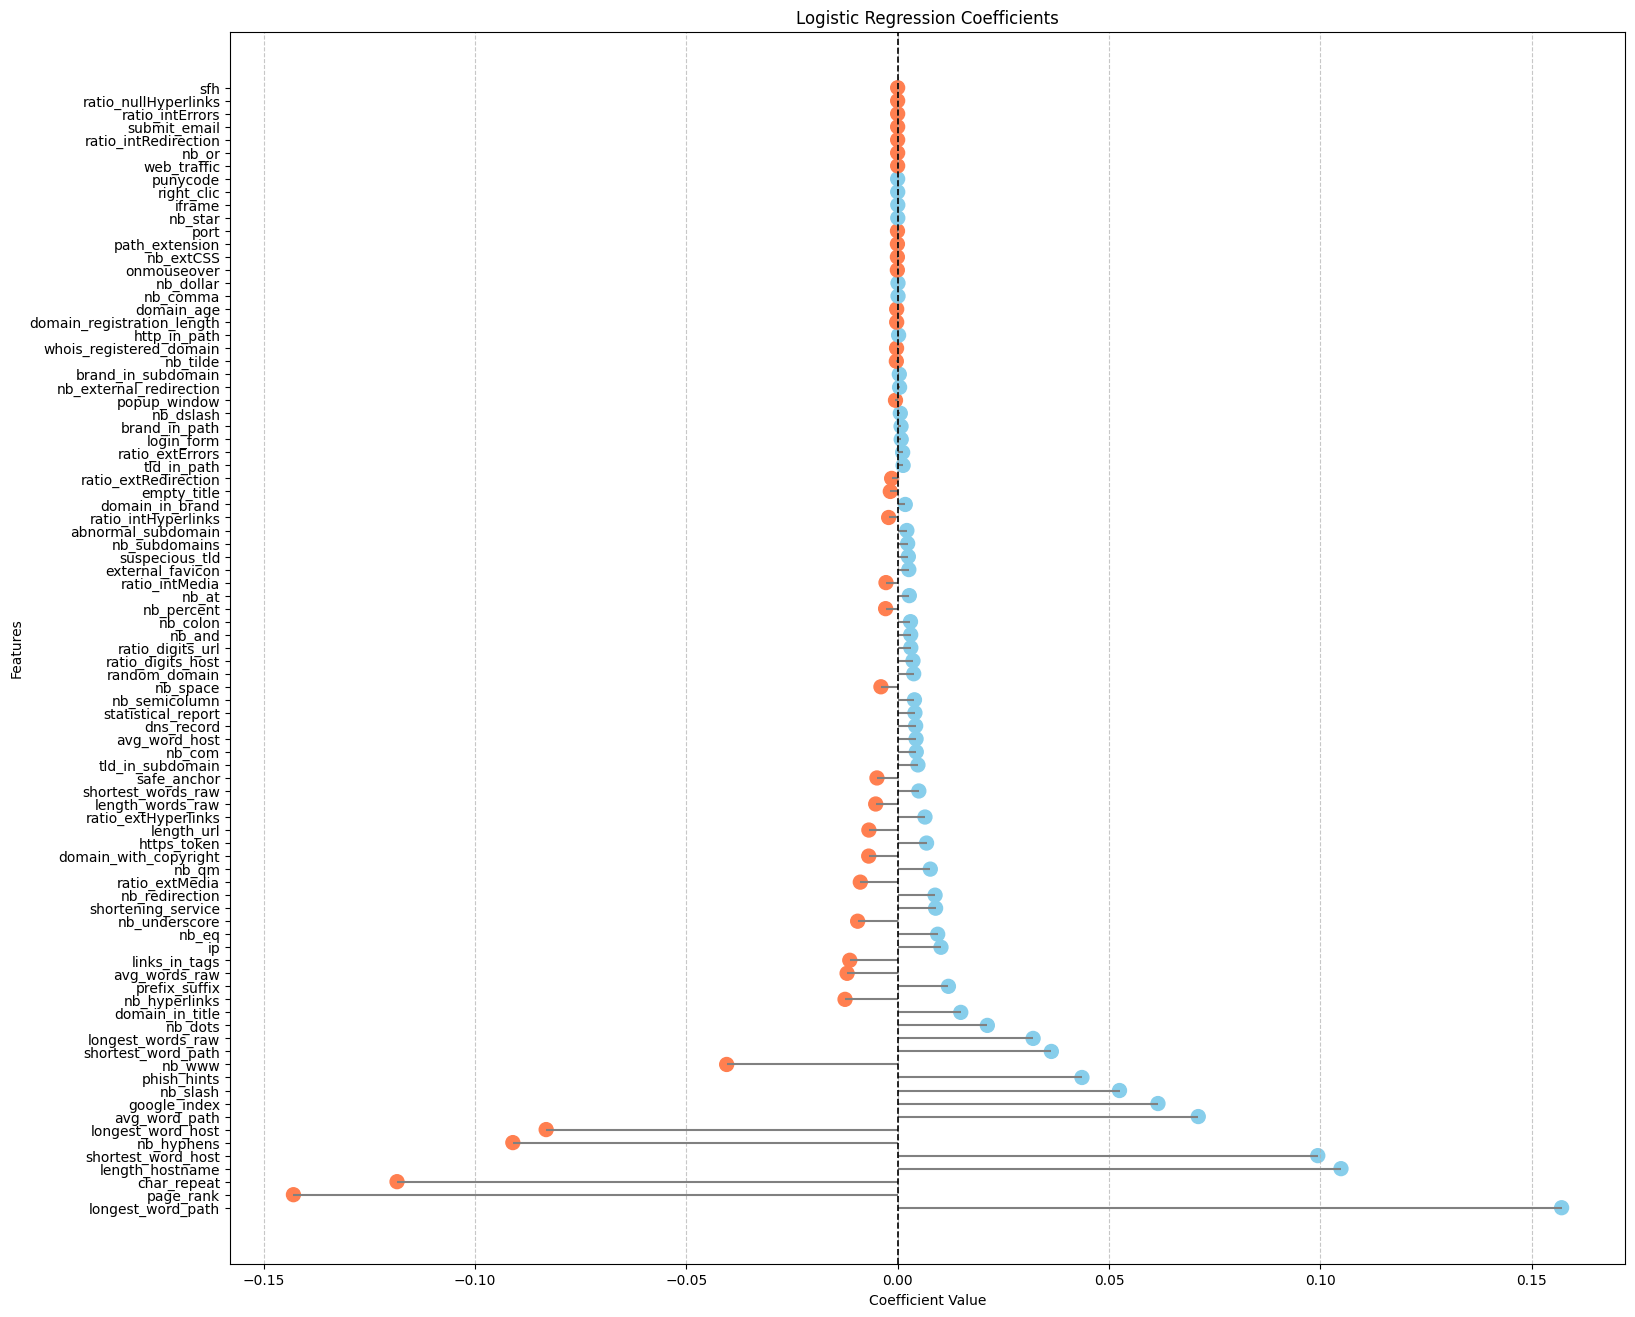

In [156]:
model = log_reg_return_model_only(x_train, x_dev, y_train, y_dev)

# Feature names,x_train.columns.tolist()
# Plot lollipop chart
plot_logistic_lollipop(model,x_train.columns.tolist())

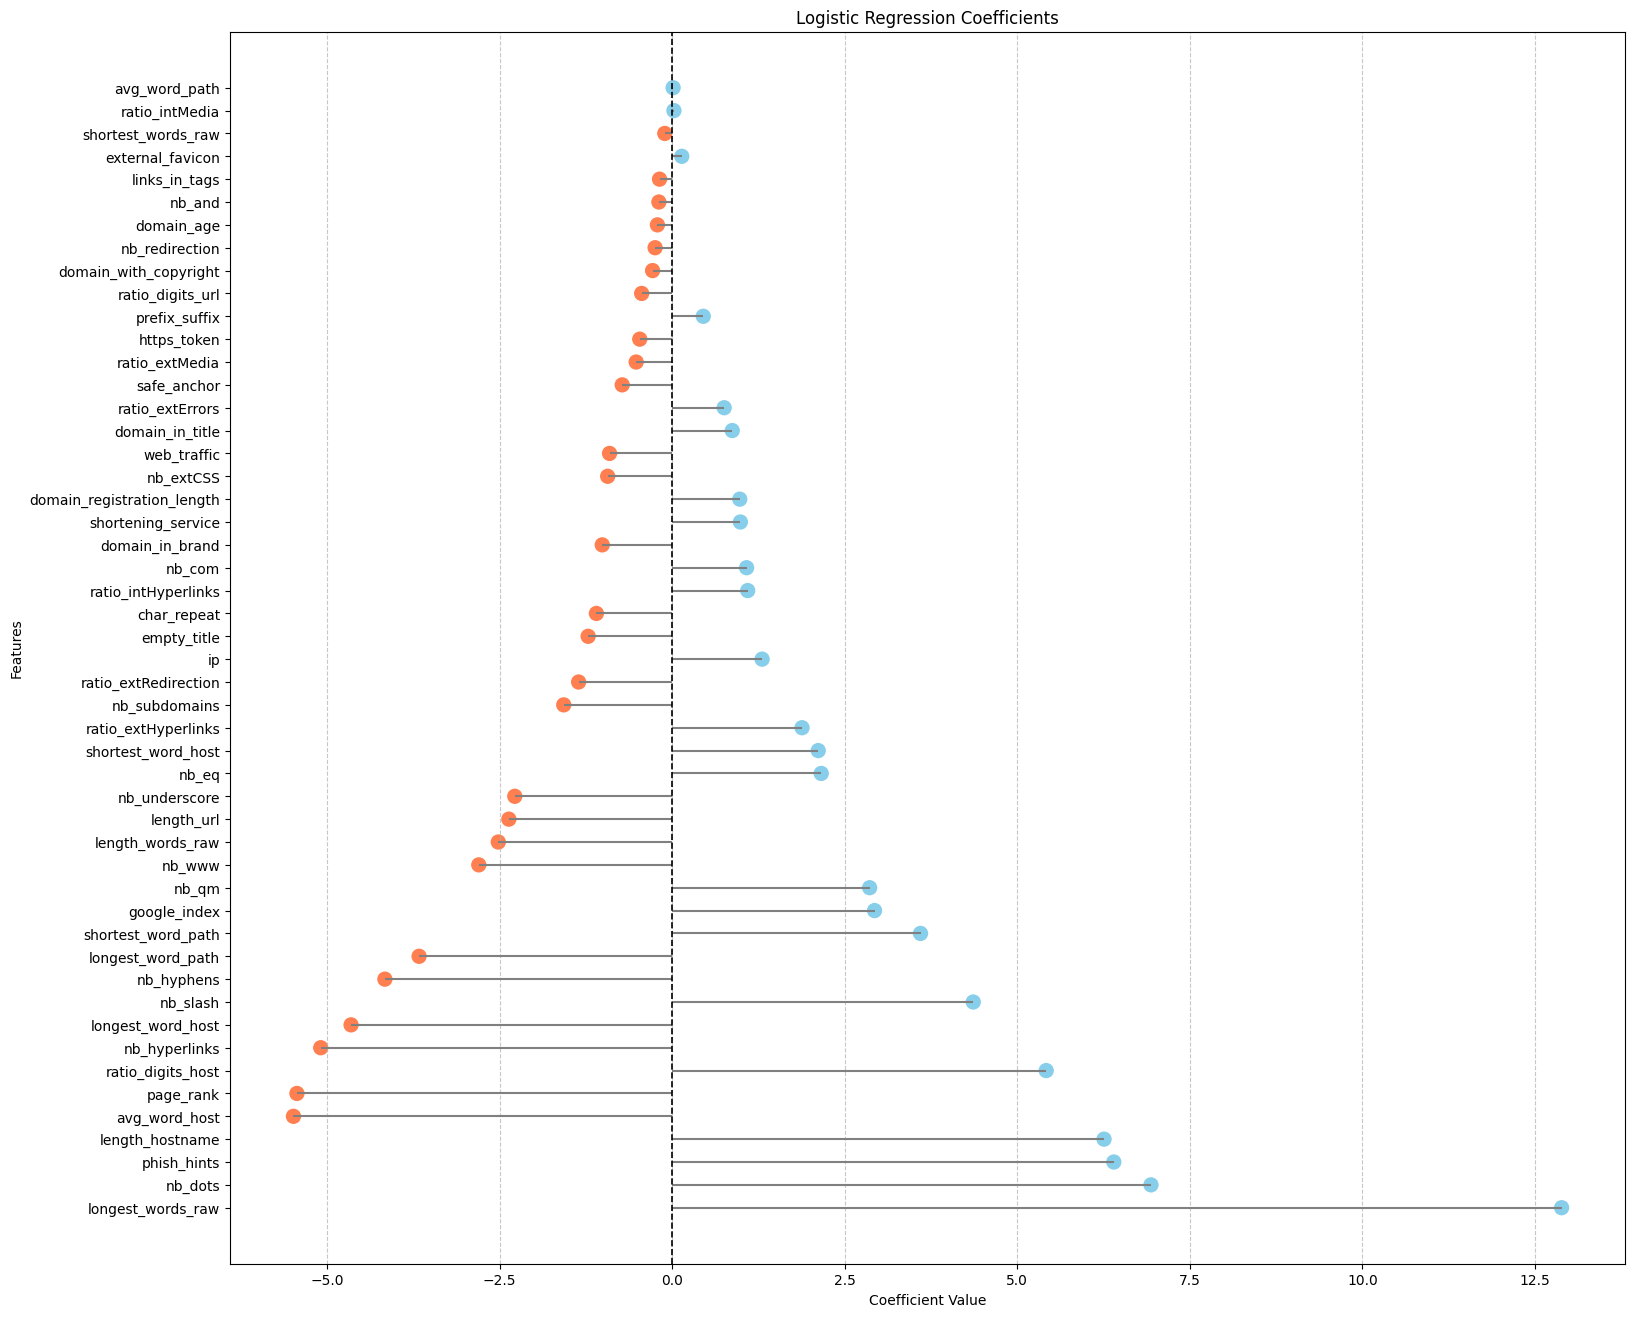

In [158]:
model = log_reg_return_model_only(df_processed, dev_set_processed, y_train, y_dev)

# Feature names,x_train.columns.tolist()
# Plot lollipop chart
plot_logistic_lollipop(model,df_processed.columns.tolist())